# Zipping Calibration Study Analysis

The purpose of this study is to assess whether our zipping paradigm can possibly yield large enough item-specific differences in RT.
We are also hoping to compare the task-general learning to these item-specific differences.

To do this we created a common/ rare design, where people perform the zipping task on a 50-50 split of two common composite stimuli (that are each probed in a specific direction), and a set of random composite stimuli.



In [361]:
import os
import sys
import urllib, io
import pickle

import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 
from IPython.core.display import HTML 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [362]:
experiment_name = 'zipping'

## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')

# paths specific to this experiment
experiment_results_dir = os.path.join(results_dir, experiment_name)
plot_dir = os.path.join(experiment_results_dir,'plots')
csv_dir = os.path.join(experiment_results_dir,'csv')
json_dir = os.path.join(experiment_results_dir,'json')

png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [363]:
# set vars 
auth = pd.read_csv(os.path.join(proj_dir, 'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['block_construction']
coll = db['zipping_calibration']

# which iteration name should we use?
# iteration_name = 'zipping_calibration_sona_masks_0' #'zipping_calibration_sona_dev'
# iteration_name = 'zipping_calibration_pilot_3_sona' # 'zipping_calibration_pilot_3_prolific'
# iteration_name = 'zipping_calibration_pilot_3_prolific' 
iteration_name = 'zipping_calibration_pilot_3_sona_stims_1' 

iteration_names = [iteration_name]

# variables to check integrity of data
# numTrials = 8

In [364]:
query = coll.find()
df_all = pd.DataFrame(query)
df_all.iterationName.unique()

array(['zipping_calibration_dev', 'zipping_calibration_sona_pilot',
       'zipping_calibration_sona_pilot_2', 'zipping_calibration_sona_dev',
       'zipping_calibration_sona_masks_0',
       'zipping_calibration_sona_masks_0_dev',
       'zipping_calibration_pilot_3_dev', 'zipping_calibration_pilot_3',
       'zipping_calibration_pilot_3_test',
       'zipping_calibration_pilot_3_sona_test',
       'zipping_calibration_pilot_3_prolific',
       'zipping_calibration_pilot_3_sona',
       'zipping_calibration_pilot_3_sona_stims_1'], dtype=object)

In [365]:
query = coll.find({"$and":[
                        {'trial_type':'survey-text'},
#                         {'eventType':'trialEnd'},
                        {'iterationName': { '$in': iteration_names }}, #use this if one iteration name
#                         {'prolificPID': '5b681e2c7a68ea0001ca7f08'}]
                        ]})
df_survey = pd.DataFrame(query)
list(df_survey['response'])

[{'technical': 'No', 'confused': 'Nothing', 'comments': ''},
 {'technical': 'no', 'confused': 'no', 'comments': 'no'},
 {'technical': 'None',
  'confused': 'In the beginning yes but I got the hang of it',
  'comments': 'It was somewhat fun, but my eyes got tired '},
 {'technical': 'No', 'confused': 'No', 'comments': 'No'},
 {'technical': 'no', 'confused': 'no', 'comments': 'no'},
 {'technical': 'no', 'confused': 'No', 'comments': 'No'},
 {'technical': 'no', 'confused': 'no', 'comments': 'no'},
 {'technical': 'No',
  'confused': 'No',
  'comments': 'I kept accidentally pressing M for yes and Z for no when I tried reacting too fast'},
 {'technical': 'no', 'confused': 'no', 'comments': 'no, thank you!'},
 {'technical': 'no', 'confused': 'no', 'comments': ''},
 {'technical': 'no', 'confused': 'nothing', 'comments': 'no '},
 {'technical': 'No',
  'confused': 'The instructions were very clear and easy to  understand :)',
  'comments': ''},
 {'technical': 'no', 'confused': 'no', 'comments': '

In [366]:
query = coll.find({"$and":[
                        {'trial_type':'tower-zipping'},
#                         {'datatype':'trial_end'},
                        {'iterationName': { '$in': iteration_names}}, #use this if one iteration name
#                         {'prolificPID': '5b681e2c7a68ea0001ca7f08'}]
                        ]})
df_zip = pd.DataFrame(query)
df_zip

,_id,rt,stimulus,response,response_correct,stimURL,practice,composite_id,composite_duration,gap_duration,...,datatype,experimentName,iterationName,workerID,gameID,response_key_dict,studyLocation,block_number,condition,composite_talls_name
0,6261d4815698fd325c0a9992,3382.0,../img/practice_trials/practice_square_composi...,m,1,https://zipping-composites-png-rerender.s3.ama...,True,None,1000,1000,...,trial_end,block_construction_zipping,zipping_calibration_pilot_3_sona_stims_1,36182,7664-0360a6a4-a101-4225-a944-a2079376259d,"{'valid': 'm', 'invalid': 'z'}",SONA,NaN,NaN,NaN
1,6261d4885698fd325c0a9993,2040.0,../img/practice_trials/practice_square_composi...,m,1,https://zipping-composites-png-rerender.s3.ama...,True,None,1000,1000,...,trial_end,block_construction_zipping,zipping_calibration_pilot_3_sona_stims_1,36182,7664-0360a6a4-a101-4225-a944-a2079376259d,"{'valid': 'm', 'invalid': 'z'}",SONA,NaN,NaN,NaN
2,6261d48e5698fd325c0a9994,973.8,../img/practice_trials/practice_square_composi...,z,1,https://zipping-composites-png-rerender.s3.ama...,True,None,1000,1000,...,trial_end,block_construction_zipping,zipping_calibration_pilot_3_sona_stims_1,36182,7664-0360a6a4-a101-4225-a944-a2079376259d,"{'valid': 'm', 'invalid': 'z'}",SONA,NaN,NaN,NaN
3,6261d4945698fd325c0a9995,1068.0,../img/practice_trials/practice_square_composi...,z,1,https://zipping-composites-png-rerender.s3.ama...,True,None,1000,1000,...,trial_end,block_construction_zipping,zipping_calibration_pilot_3_sona_stims_1,36182,7664-0360a6a4-a101-4225-a944-a2079376259d,"{'valid': 'm', 'invalid': 'z'}",SONA,NaN,NaN,NaN
4,6261d4a75698fd325c0a999a,807.1,https://zipping-composites-png-rerender.s3.ama...,z,1,https://zipping-composites-png-rerender.s3.ama...,False,talls_125_118,600,400,...,trial_end,block_construction_zipping,zipping_calibration_pilot_3_sona_stims_1,36182,7664-0360a6a4-a101-4225-a944-a2079376259d,"{'valid': 'm', 'invalid': 'z'}",SONA,0.0,common_tall,talls_125_118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,6262e5505698fd325c0aa21c,1471.0,https://zipping-composites-png-rerender.s3.ama...,z,0,https://zipping-composites-png-rerender.s3.ama...,False,talls_101_097,800,200,...,trial_end,block_construction_zipping,zipping_calibration_pilot_3_sona_stims_1,31694,9761-66425f87-665e-434f-8597-0d6f4515b47f,"{'valid': 'z', 'invalid': 'm'}",SONA,0.0,rare,talls_101_097
2021,6262e5555698fd325c0aa21d,1129.1,https://zipping-composites-png-rerender.s3.ama...,m,1,https://zipping-composites-png-rerender.s3.ama...,False,talls_100_118,800,200,...,trial_end,block_construction_zipping,zipping_calibration_pilot_3_sona_stims_1,31694,9761-66425f87-665e-434f-8597-0d6f4515b47f,"{'valid': 'z', 'invalid': 'm'}",SONA,0.0,common_tall,talls_100_118
2022,6262e5685698fd325c0aa220,926.4,https://zipping-composites-png-rerender.s3.ama...,z,1,https://zipping-composites-png-rerender.s3.ama...,False,talls_115_127,800,200,...,trial_end,block_construction_zipping,zipping_calibration_pilot_3_sona_stims_1,31694,9761-66425f87-665e-434f-8597-0d6f4515b47f,"{'valid': 'z', 'invalid': 'm'}",SONA,1.0,common_wide,talls_115_127
2023,6262e56d5698fd325c0aa221,1006.1,https://zipping-composites-png-rerender.s3.ama...,m,1,https://zipping-composites-png-rerender.s3.ama...,False,talls_100_118,800,200,...,trial_end,block_construction_zipping,zipping_calibration_pilot_3_sona_stims_1,31694,9761-66425f87-665e-434f-8597-0d6f4515b47f,"{'valid': 'z', 'invalid': 'm'}",SONA,1.0,common_tall,talls_100_118


In [367]:
df_zip.columns

Index(['_id', 'rt', 'stimulus', 'response', 'response_correct', 'stimURL',
       'practice', 'composite_id', 'composite_duration', 'gap_duration',
       'chunk_duration', 'participant_condition', 'compatible_trial',
       'validity', 'part_type', 'part_a', 'part_b', 'stimVersion',
       'stimVersionInd', 'compatible_condition', 'trial_num', 'key_presses',
       'trial_type', 'trial_index', 'time_elapsed', 'internal_node_id',
       'datatype', 'experimentName', 'iterationName', 'workerID', 'gameID',
       'response_key_dict', 'studyLocation', 'block_number', 'condition',
       'composite_talls_name'],
      dtype='object')

In [368]:
df_zip = df_zip[~df_zip.workerID.isna()]
df_survey = df_survey[~df_survey.workerID.isna()]

In [369]:
df_zip.loc[:,'common'] = ~(df_zip.condition == 'rare')

### Remove identifiable info and save

In [370]:
df_zip = df_zip.drop('workerID', axis='columns')
df_zip.to_csv('df_zipping_{}.csv'.format(iteration_name))

### Apply exclusion criteria

In [371]:
df_zip_trials = df_zip[~df_zip.condition.isna()]
df_zip_w_practice = df_zip.copy()
# TODO: replace with df_zip.practice when column added

In [372]:
# complete datasets
full_dataset_ids = (df_zip_trials.groupby('gameID').apply(len) == 144)\
                        .index[(df_zip_trials.groupby('gameID').apply(len) == 144)]
df_zip_trials = df_zip_trials.loc[df_zip.gameID.isin(full_dataset_ids)]

In [373]:
df_zip = df_zip_trials

In [374]:
# low accuracy
p = df_zip.groupby('gameID').response_correct.mean() > 0.6
ppt_greater_chance = list(p[p].index)
print(str(len(df_zip.groupby('gameID')) - len(ppt_greater_chance)) + ' ppts removed')

df_zip = df_zip[df_zip.gameID.isin(ppt_greater_chance)].reset_index()
print(str(len(ppt_greater_chance)) + ' ppts left')


1 ppts removed
12 ppts left


In [375]:
# exclude really slow ppts

df_zip_ppt_means = df_zip.groupby(['gameID']).mean()

df_zip = df_zip[~df_zip.gameID.isin(list(df_zip_ppt_means['rt'].index[df_zip_ppt_means['rt'] > 3000]))]

print(str(df_zip.gameID.nunique()) + ' ppts left')

11 ppts left


In [376]:
# slow RTs
df_zip.loc[:,'flagRT'] = False
df_zip.loc[(df_zip.rt > 5000), 'flagRT'] = True

In [377]:
df_zip['flagRT'].sum()

7

### Add useful columns

In [136]:
df_zip.loc[:,'trial_bin'] = np.round(df_zip.trial_num/12)

### plot setup

In [137]:
sns.set_context('poster')
sns.set(font_scale=1.2)
sns.set_style('whitegrid', {'font.family':'sans-serif', 'font.sans-serif':'Avenir'})

### check study design

In [138]:
# check experiment-side saving of accuracy (response_correct) with manual calculation

df_zip.loc[:,'expected_response'] = df_zip.apply(lambda row: row.response_key_dict[row.validity],axis=1)
df_zip.loc[:,'recalculated_response_correct'] = df_zip.expected_response == df_zip.response
assert((df_zip.recalculated_response_correct == df_zip.response_correct).all())

No handles with labels found to put in legend.


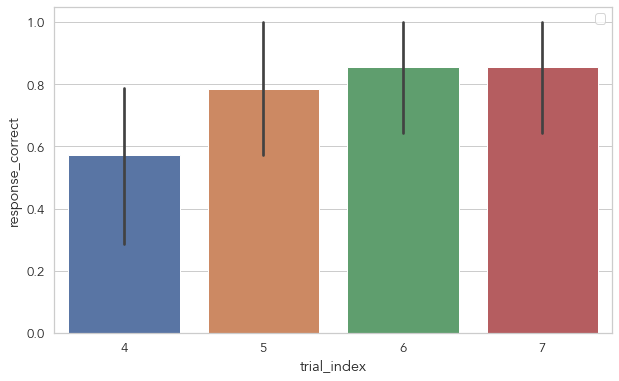

In [139]:
# So people understand practice trials?

fig = plt.figure(figsize=(10,6))

sns.barplot(data=df_zip_w_practice[df_zip_w_practice.condition.isna()], 
              y= "response_correct", 
              x= "trial_index",
              )

plt.legend(bbox_to_anchor=(1,1))

In [140]:
df_zip.groupby('composite_duration')['gameID'].nunique()

composite_duration
600    6
800    5
Name: gameID, dtype: int64

## Questions to answer with these analyses

*Frequency*: common vs. rare
Frequency is our main IV here.
Common vs rare over blocks.

*Zipping performance*: how good (fast and accurate) are they at the task?


#### Effect of decomposition experience on zipping performance
- Are common trials faster (particularly in later reps)?
- What contributes to a larger diff between common and rare?
    - Composite duration? (i.e. the time people have to look at and decompose the stimulus?
- Is there a d' difference?
- Is there an accuracy difference
- Plot number of times that a composite has been seen so far?

#### Does practice on a part (rather than a whole composite) improve zipping performance?
- Plot number of times that a part has been seen so far?

#### Which particular stimuli are most susceptible to frequency effects?
- Which composites?
- Which parts?


#### 

#### 

#### 


## Effect of decomposition experience on zipping performance

### RT

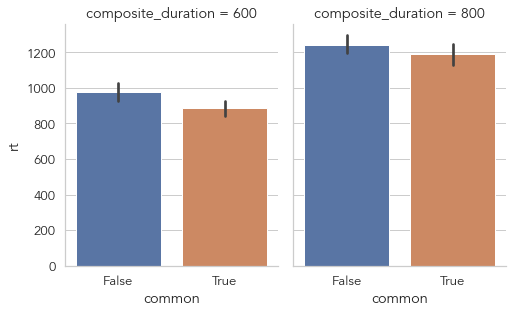

In [141]:
# Are people faster in common trials?

g = sns.catplot(data=df_zip[~df_zip.flagRT],
                col="composite_duration", 
                x="common",
                y="rt", 
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)

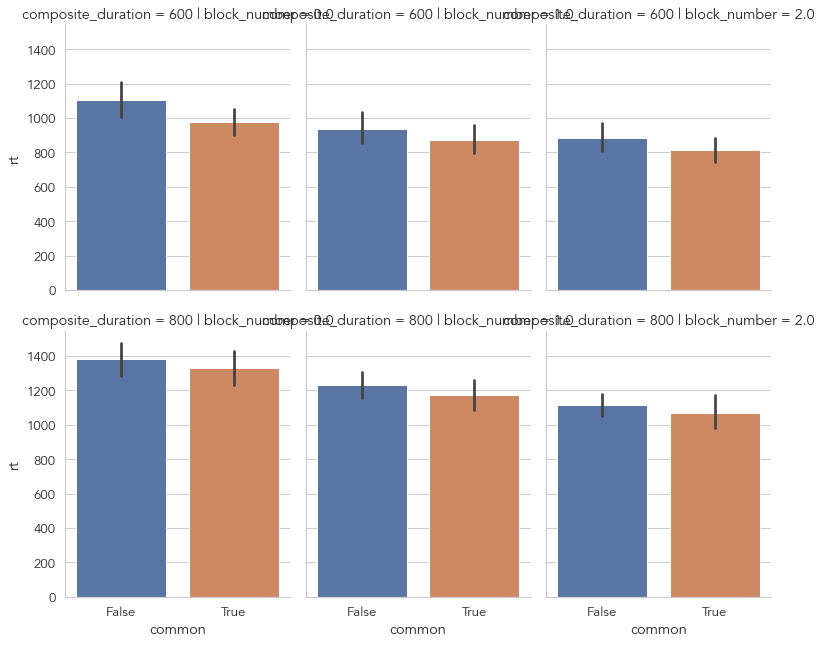

In [155]:
# Are people faster in compatible trials?

g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                row="composite_duration", 
                col="block_number",
                x="common",
                y="rt", 
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)

<Figure size 720x432 with 0 Axes>

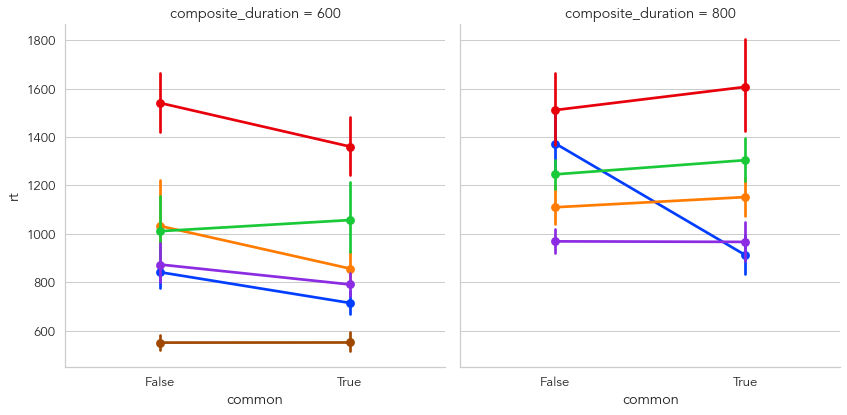

In [143]:
# Are people faster in compatible trials?

fig = plt.figure(figsize=(10,6))

g = sns.FacetGrid(df_zip[~df_zip.flagRT], col="composite_duration", height=6) # row="block_number"

g.map_dataframe(sns.pointplot,
                  y="rt",
                  x="common", 
                  hue="gameID",
                  palette="bright")

(array([2., 2., 0., 2., 1., 0., 1., 1., 1., 1.]),
 array([0.68055556, 0.70486111, 0.72916667, 0.75347222, 0.77777778,
        0.80208333, 0.82638889, 0.85069444, 0.875     , 0.89930556,
        0.92361111]),
 <BarContainer object of 10 artists>)

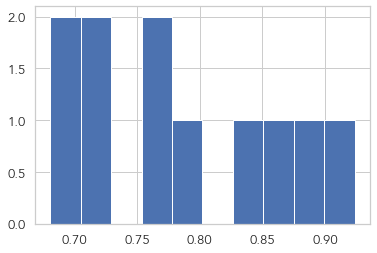

In [144]:
plt.hist(df_zip.groupby('gameID')['response_correct'].mean(), bins=10)

In [145]:
df_zip.groupby('gameID')['response_correct'].mean()

gameID
0023-f256dea4-1f52-466b-aeac-bb16f9ecc672    0.722222
2541-f70e6381-4451-441e-973e-b9554744ecc7    0.861111
3040-83114c43-ae25-4c9b-ba57-11938aa0005d    0.715278
3095-e33efa93-3cb0-4d82-81a3-33c8d8bee9cd    0.680556
6756-7331a605-8eae-49d4-8126-0634ce43a8fc    0.763889
7501-204254bb-1baf-436c-8728-c434ddc6bcee    0.923611
7664-0360a6a4-a101-4225-a944-a2079376259d    0.756944
7792-d6a33854-bcfc-4d6f-924b-933d4030270f    0.701389
7979-3cd2b2c8-ab03-4e28-98ff-7a3b27e25d97    0.798611
9268-c6d3618b-0216-4ca5-a203-9c8fdf8db6c2    0.888889
9773-7420a101-9ddc-4420-b4ee-beed366cf954    0.833333
Name: response_correct, dtype: float64

### Plot differences between common and rare

In [271]:
def rare_common_diff(means, value_col='rt'):
    '''
    Given a dataframe of means
    '''
    
    diffs = (means.loc[means.common, value_col].reset_index(drop=True) - \
            means.loc[~means.common, value_col].reset_index(drop=True))
    
    assert(len(diffs) == 1)
    
    return pd.Series({value_col+'_diff' : diffs[0]})

In [291]:
def get_means(df, grouping_cols, value_col='rt'):
    '''
    grouping_cols: columns to average over
    value_col: values you want differences of
    '''
    df_means = df.groupby(grouping_cols)[value_col].mean().reset_index()

    return df_means

In [292]:
def get_diffs(df, grouping_cols, comparison_col='common', value_col='rt'):
    '''
    grouping_cols: columns to average over
    comparison_col: column with binary variable to compare
    value_col: values you want differences of
    '''
    df_means = get_means(df, 
                         grouping_cols = grouping_cols + [comparison_col], 
                         value_col = value_col)
    
    df_diffs = df_means.groupby(grouping_cols).apply(rare_common_diff, value_col=value_col)
    
    return df_diffs.reset_index()

In [307]:
df_rt_diffs = get_diffs(df_zip,
                      grouping_cols = ['composite_duration', 'gameID'],
                      comparison_col = 'common',
                      value_col = 'rt')
# df_diffs

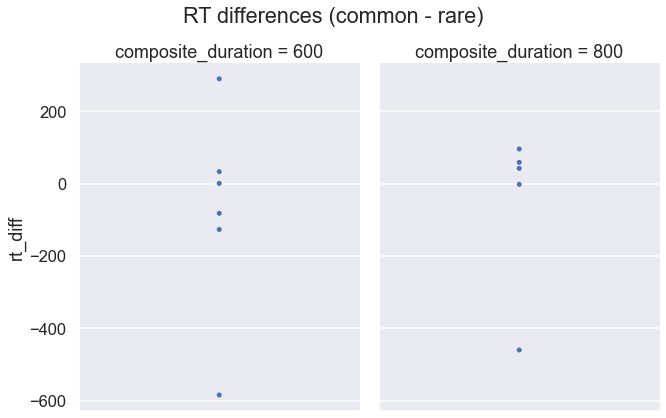

In [425]:
# Is there a frequency effect on RT? How does it compare across composite durations?

g = sns.catplot(col="composite_duration", 
                y="rt_diff",
                dodge=True,
                kind="swarm",
                data=df_rt_diffs,
                height=6,
                aspect=0.8)

g.fig.subplots_adjust(top=0.85)
_ = g.fig.suptitle('RT differences (common - rare)')

In [313]:
df_acc_diffs = get_diffs(df_zip,
                      grouping_cols = ['composite_duration', 'gameID'],
                      comparison_col = 'common',
                      value_col = 'response_correct')
# df_diffs

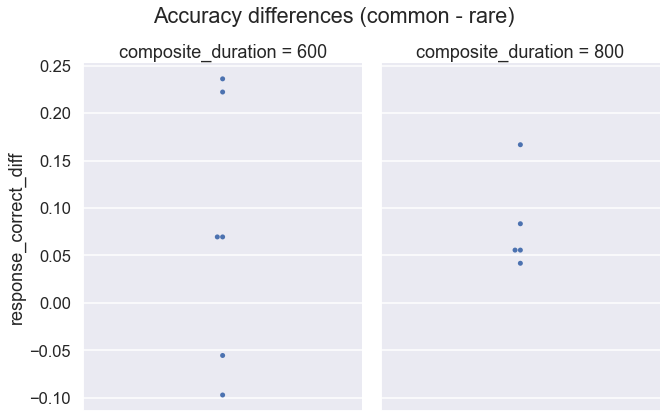

In [424]:
# Is there a frequency effect on accuracy? How does it compare across composite durations?

g = sns.catplot(col="composite_duration", 
                y="response_correct_diff",
                dodge=True,
                kind="swarm",
                data=df_acc_diffs,
                height=6,
                aspect=0.8)

g.fig.subplots_adjust(top=0.85)
_ = g.fig.suptitle('Accuracy differences (common - rare)')

In [251]:
def plot_diffs(group):
    plt.figure()
    plt.hist(group,
            bins=10)

#### Differences across blocks

Can I go more granular than diff between common and rare for each ppt?

In [393]:
df_block_rt_diffs = get_diffs(df_zip[~df_zip.flagRT],
                      grouping_cols = ['composite_duration', 'gameID', 'block_number'],
                      comparison_col = 'common',
                      value_col = 'rt')
# df_block_diffs

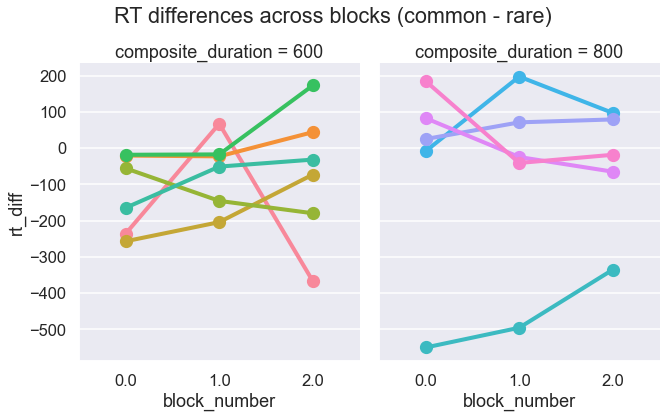

In [423]:
# Does a frequency effect on RT develop over time? How does it compare across composite durations?

g = sns.catplot(col="composite_duration", 
                y="rt_diff",
                hue="gameID",
                x="block_number",
                dodge=False,
                kind="point",
                data=df_block_rt_diffs,
                height=6,
                aspect=0.8,
                legend = False)

g.fig.subplots_adjust(top=0.85)
_ = g.fig.suptitle('RT differences across blocks (common - rare)')

In [395]:
df_block_acc_diffs = get_diffs(df_zip[~df_zip.flagRT],
                      grouping_cols = ['composite_duration', 'gameID', 'block_number'],
                      comparison_col = 'common',
                      value_col = 'response_correct')

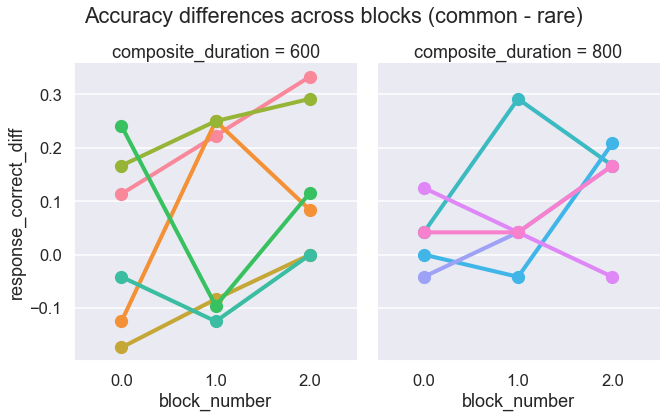

In [422]:
# Is there a frequency effect on accuracy develop over time? How does it compare across composite durations?

g = sns.catplot(col="composite_duration", 
                y="response_correct_diff",
                hue="gameID",
                x="block_number",
                dodge=False,
                kind="point",
                data=df_block_acc_diffs,
                height=6,
                aspect=0.8,
                legend = False)
g.fig.subplots_adjust(top=0.85)
_ = g.fig.suptitle('Accuracy differences across blocks (common - rare)')

#### What contributes to larger diffs in RT?

In [397]:
df_block_orientation_rt_diffs = get_diffs(df_zip[~df_zip.flagRT],
                      grouping_cols = ['composite_duration','part_type', 'gameID', 'block_number'],
                      comparison_col = 'common',
                      value_col = 'rt')
# df_block_diffs

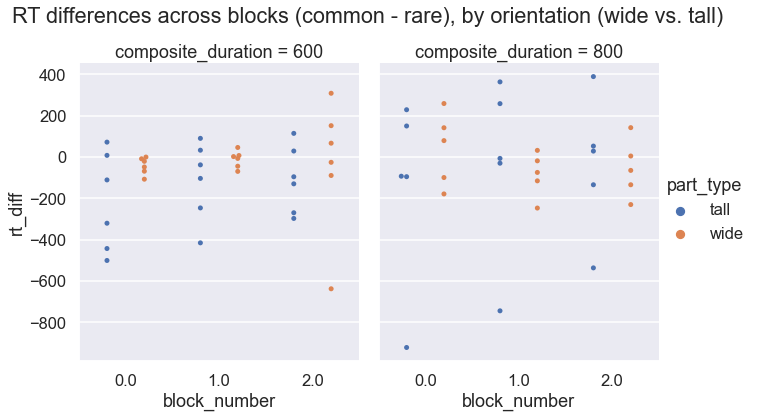

In [411]:
# Is there a frequency effect on accuracy develop over time? How does it compare across composite durations?

g = sns.catplot(col="composite_duration", 
                y="rt_diff",
                hue="part_type",
                x="block_number",
                dodge=True,
                kind="swarm",
                data=df_block_orientation_rt_diffs,
                height=6,
                aspect=0.8,
                legend = True)
g.fig.subplots_adjust(top=0.85)
_ = g.fig.suptitle('RT differences across blocks (common - rare), by orientation (wide vs. tall)')

## Find stimuli that yield the biggest frequency effects (i.e. are learnable)

In [383]:
df_block_composite_rt_diffs = get_diffs(df_zip,
                      grouping_cols = ['composite_duration','composite_id','block_number'],
                      comparison_col = 'common',
                      value_col = 'rt')
# df_block_diffs

In [385]:
df_block_composite_rt_diffs

,composite_duration,composite_id,block_number,rt_diff
0,600,talls_097_102,0.0,608.866667
1,600,talls_097_102,1.0,377.361667
2,600,talls_097_102,2.0,560.035000
3,600,talls_097_116,0.0,NaN
4,600,talls_097_116,1.0,NaN
...,...,...,...,...
151,800,talls_126_115,1.0,NaN
152,800,talls_126_115,2.0,NaN
153,800,talls_127_122,0.0,NaN
154,800,talls_127_122,1.0,NaN


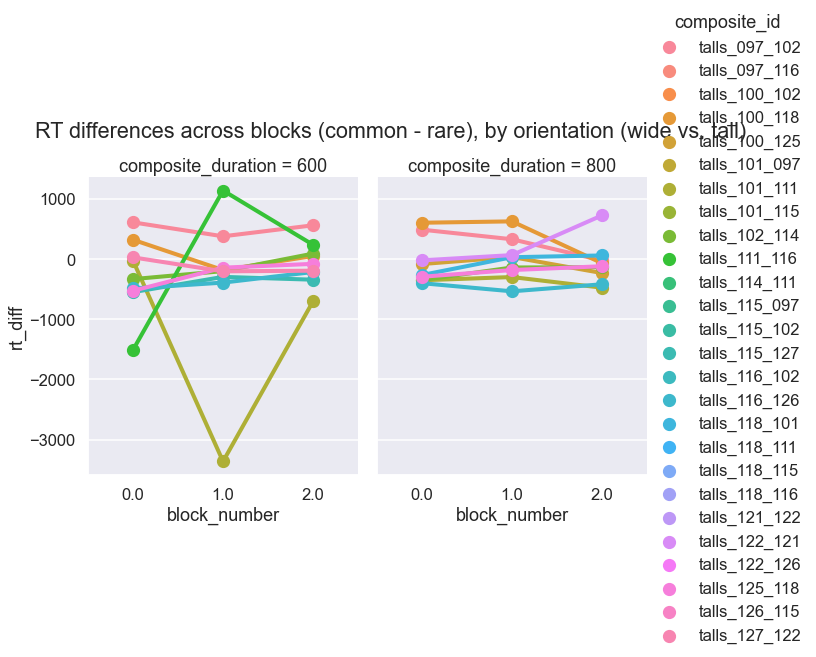

In [415]:
# Do any particular composites stand out as most learnable?

g = sns.catplot(col="composite_duration", 
                y="rt_diff",
                hue="composite_id",
                x="block_number",
                dodge=False,
                kind="point",
                data=df_block_composite_rt_diffs,
                height=6,
                aspect=0.8,
                legend = True)
g.fig.subplots_adjust(top=0.85)
_ = g.fig.suptitle('RT differences across blocks (common - rare), by orientation (wide vs. tall)')

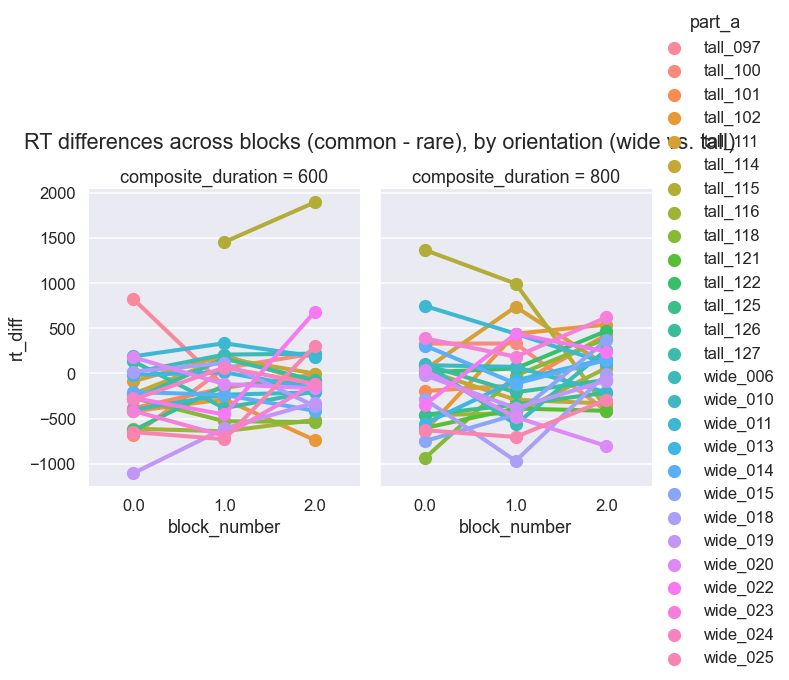

In [414]:
# Are there any individual parts that stand out as most learnable? 
# WARNING [looking only at part a here- swap in for part b too/ aggregate somehow]

df_block_part_rt_diffs = get_diffs(df_zip[~df_zip.flagRT],
                      grouping_cols = ['composite_duration','part_a','block_number'],
                      comparison_col = 'common',
                      value_col = 'rt')
# df_block_diffs

g = sns.catplot(col="composite_duration", 
                y="rt_diff",
                hue="part_a",
                x="block_number",
                dodge=False,
                kind="point",
                data=df_block_part_rt_diffs,
                height=6,
                aspect=0.8,
                legend = True)
g.fig.subplots_adjust(top=0.85)
_ = g.fig.suptitle('RT differences across blocks (common - rare), by orientation (wide vs. tall)')

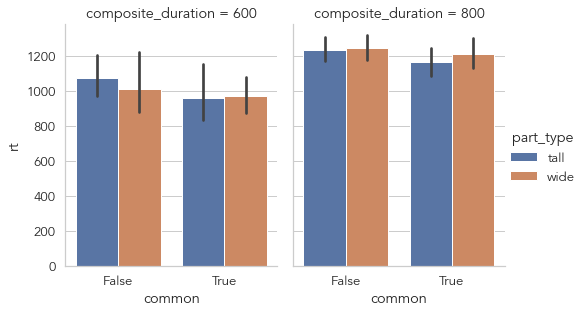

In [154]:
# Are people faster in compatible trials?

g = sns.catplot(col="composite_duration", 
                x="common",
                y="rt", 
                hue="part_type",
                dodge=True,
                kind="bar",
                data=df_zip,
                height=4.6,
                aspect=0.8)

In [790]:
df_zip.groupby('common')['rt'].mean()

common
False    1051.363573
True      972.377462
Name: rt, dtype: float64

### accuracy

<AxesSubplot:xlabel='composite_duration', ylabel='response_correct'>

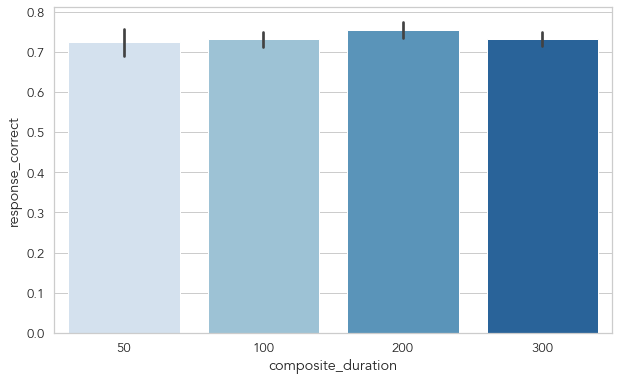

In [791]:
fig = plt.figure(figsize=(10,6))

sns.barplot(data=df_zip, 
              y="response_correct", 
              x="composite_duration",
              palette='Blues')
#               hue="gameID")
# plt.legend(bbox_to_anchor=(1.0,1))

No handles with labels found to put in legend.


Text(0.5, 1.0, 'accuracy')

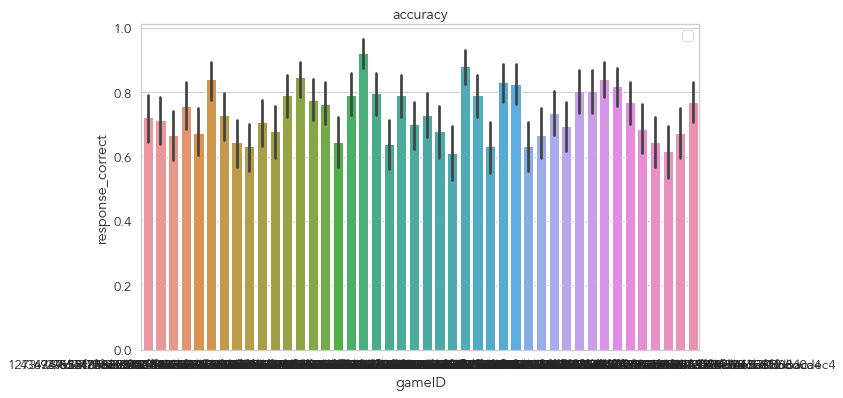

In [792]:
fig = plt.figure(figsize=(10,6))

sns.barplot(data=df_zip, 
              y="response_correct", 
#               x="composite_duration",
              x="gameID")
plt.legend(bbox_to_anchor=(1.0,1))
plt.title('accuracy')

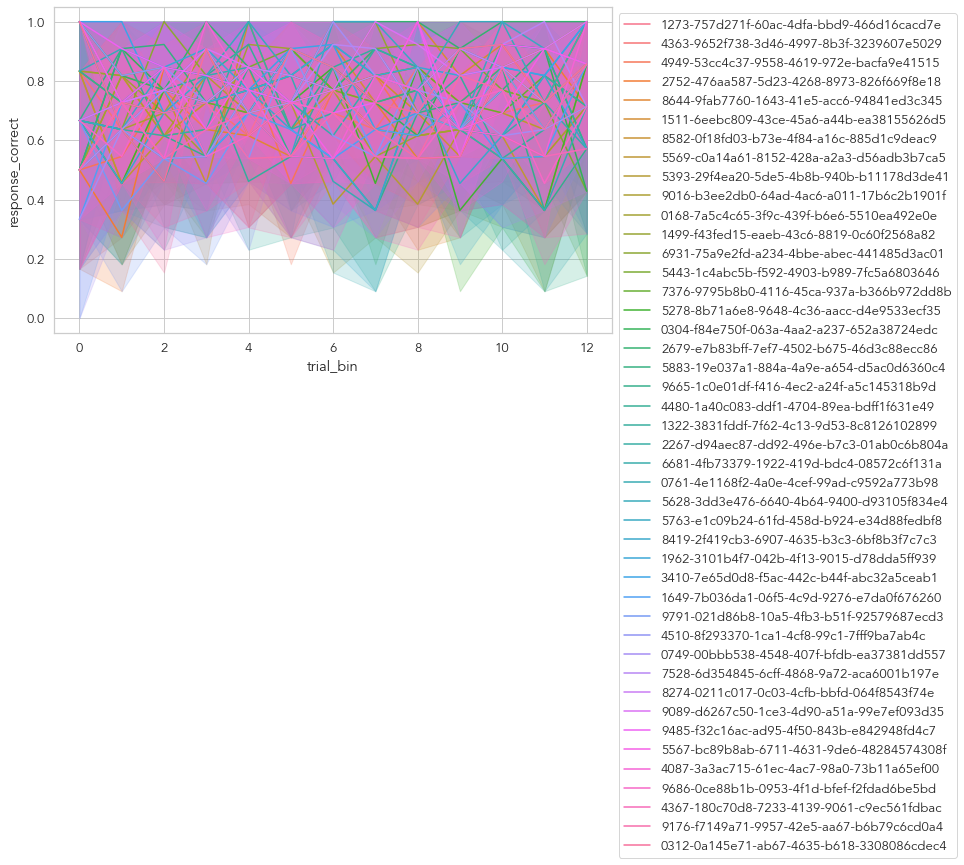

In [793]:
fig = plt.figure(figsize=(10,6))

sns.lineplot(data=df_zip, 
              y="response_correct", 
              x="trial_bin",
              hue="gameID")

plt.legend(bbox_to_anchor=(1,1))

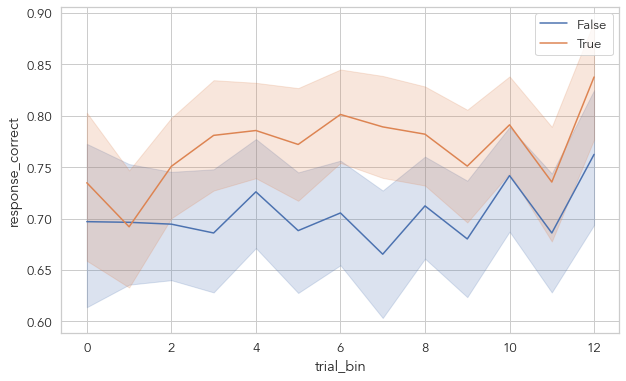

In [794]:
fig = plt.figure(figsize=(10,6))

sns.lineplot(data=df_zip, 
              y="response_correct", 
              x="trial_bin",
              hue="common")

plt.legend(bbox_to_anchor=(1,1))

No handles with labels found to put in legend.


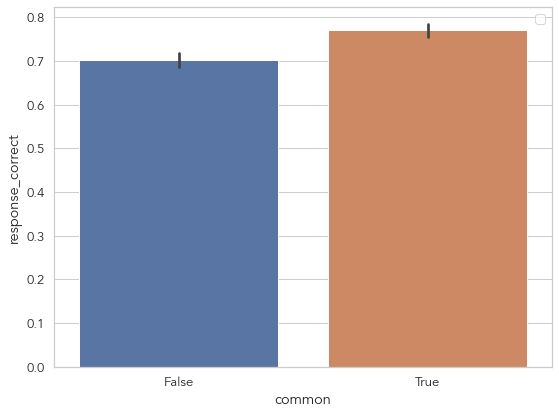

In [795]:
# How does accuracy change across condition?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip,
                y= "response_correct",
                x = "common")

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

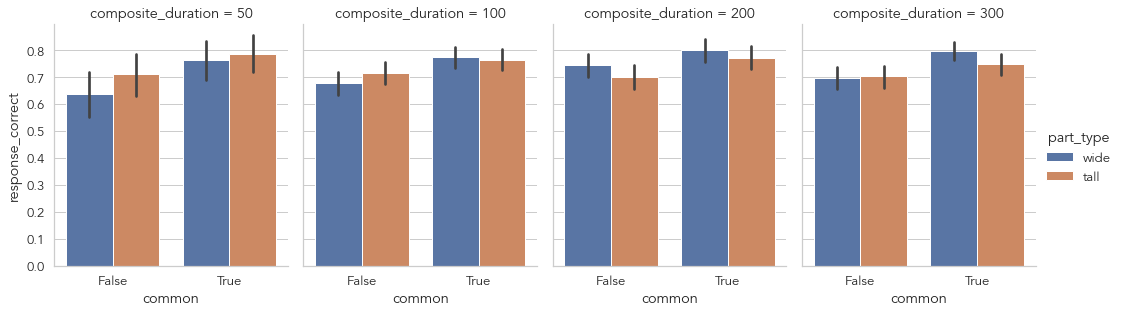

In [796]:
# Are people faster in common trials?

g = sns.catplot(col="composite_duration", 
                x="common",
                y="response_correct", 
                hue="part_type",
                dodge=True,
                kind="bar",
                data=df_zip[df_zip.trial_num > 12],
                height=4.6,
                aspect=0.8)

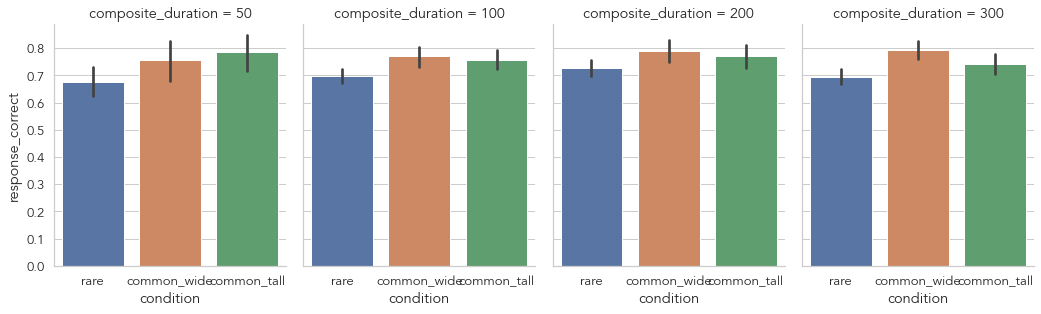

In [797]:
# Are people more accurate in compatible trials?

g = sns.catplot(col="composite_duration", 
#                 x="validity",
                y="response_correct", 
                x="condition",
                dodge=True,
                kind="bar",
                data=df_zip,
                height=4.6,
                aspect=0.8)

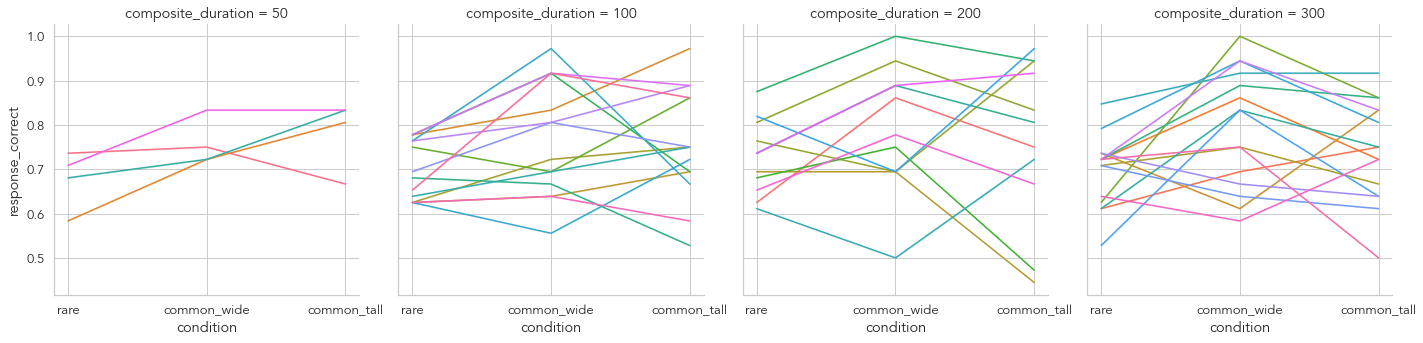

In [798]:
sns.relplot(data = df_zip,
            kind='line',
            col="composite_duration",
            x= "condition",
            y="response_correct",
            hue='gameID',
            ci=False,
            legend=False,)

### RT

No handles with labels found to put in legend.


Text(0.5, 1.0, 'RT')

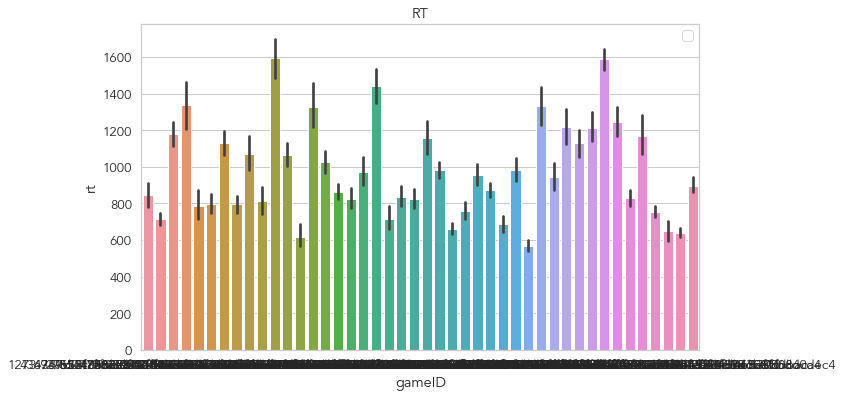

In [799]:
fig = plt.figure(figsize=(10,6))

sns.barplot(data=df_zip[~df_zip['flagRT']], 
              y="rt", 
              x="gameID")
plt.legend(bbox_to_anchor=(1.0,1))
plt.title('RT')

/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rt', ylabel='Density'>

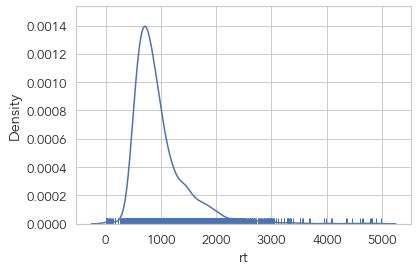

In [800]:
# sns.distplot(data=df_zip, y='rt', x="trial_index")
sns.distplot(df_zip.rt[~df_zip.flagRT], rug=True, hist=False)

<AxesSubplot:xlabel='rt', ylabel='Count'>

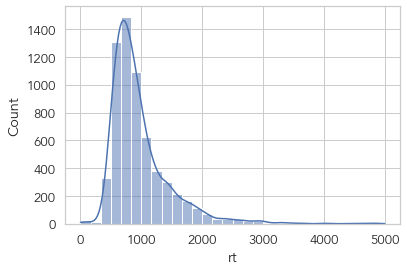

In [801]:
# sns.distplot(df_zip[(~df_zip.flagRT)].rt, rug=True, hist=False)

sns.histplot(data=df_zip[(~df_zip.flagRT)], x="rt", bins=30, kde=True)

No handles with labels found to put in legend.


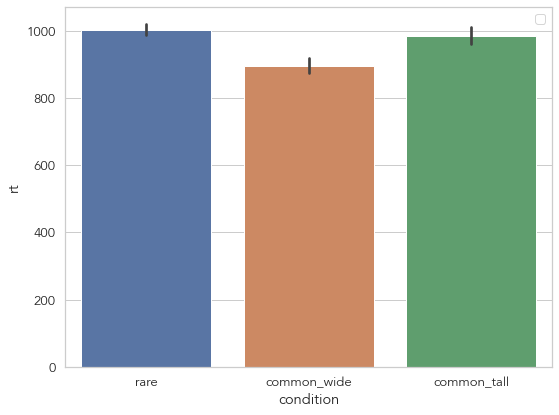

In [802]:
# Are people faster in rare/ commmon trials?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt",
                x= "condition")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

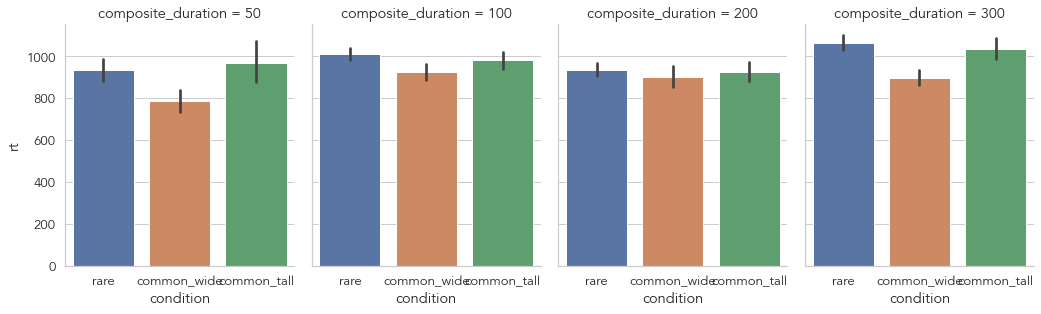

In [803]:
# Are people more accurate in compatible trials?

g = sns.catplot(data=df_zip[~df_zip.flagRT], 
                col="composite_duration", 
#                 x="validity",
                y="rt", 
                x="condition",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)

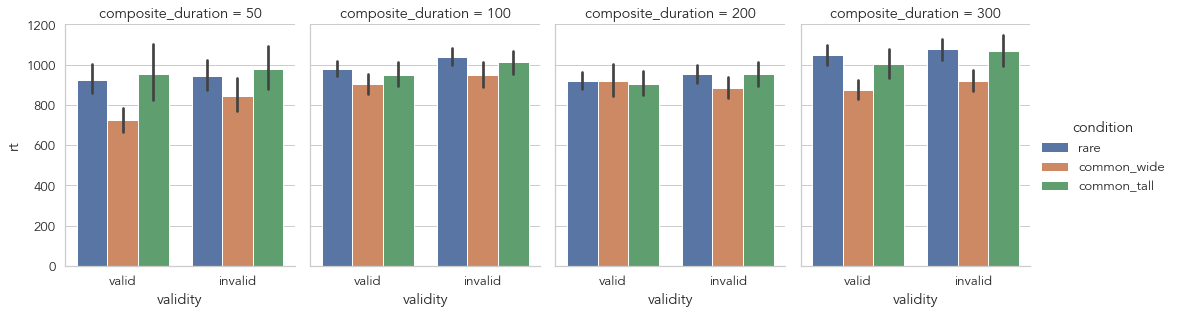

In [804]:
# Are people faster in compatible trials?

g = sns.catplot(col="composite_duration", 
                x="validity",
                y="rt", 
                hue="condition",
                dodge=True,
                kind="bar",
                data=df_zip[~df_zip.flagRT],
                height=4.6,
                aspect=0.8)

### Is there a speed accuracy trade-off?

In [805]:
df_zip_ppt_means = df_zip.groupby(['gameID']).mean()

<AxesSubplot:xlabel='response_correct', ylabel='rt'>

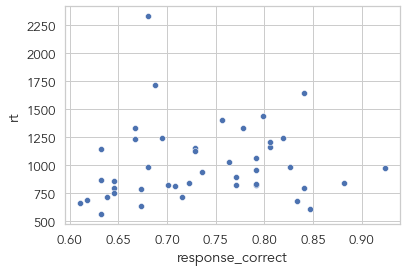

In [806]:
# are people responding slower 

sns.scatterplot(data=df_zip_ppt_means,
               y='rt',
               x='response_correct',)

In [807]:
df_zip_ppt_means = df_zip.groupby(['gameID','common']).mean()

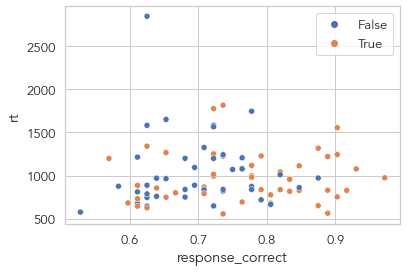

In [808]:
# are people responding slower 

sns.scatterplot(data=df_zip_ppt_means,
               y='rt',
               x='response_correct',
               hue='common',)
plt.legend(bbox_to_anchor=(1.0,1))

No handles with labels found to put in legend.


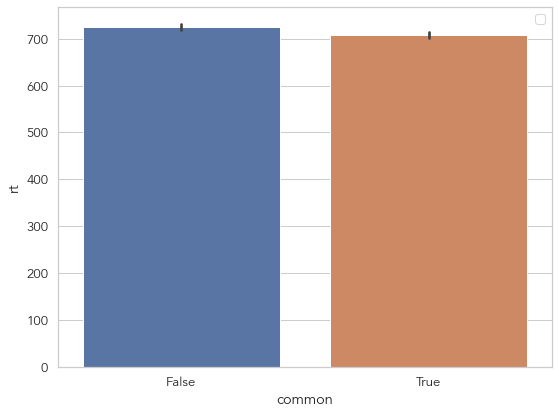

In [809]:
# Is something different going on when people respond quickly?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[df_zip.rt<1000], 
                y= "rt",
#                 x = "composite_duration",
                x= "common",)# , hue_order=['novel','compatible','incompatible'])

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

### d' analysis

In [810]:
from scipy.stats import norm

Z = norm.ppf

In [811]:
yes_trials = df_zip[df_zip.validity=='valid']

In [812]:
len(yes_trials[yes_trials.response==df_zip[df_zip.validity=='valid']['expected_response']])/ len(yes_trials)

0.7818813131313131

In [813]:
yes_trials[yes_trials.response==df_zip[df_zip.validity=='valid']]

<ipython-input-813-f2cf5706a4f9>:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  yes_trials[yes_trials.response==df_zip[df_zip.validity=='valid']]


,index,_id,rt,stimulus,response,response_correct,stimURL,practice,composite_id,composite_duration,...,gameID,response_key_dict,block_number,condition,composite_talls_name,common,flagRT,trial_bin,expected_response,recalculated_response_correct
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [814]:
yes_trials[yes_trials.response=='m']

,index,_id,rt,stimulus,response,response_correct,stimURL,practice,composite_id,composite_duration,...,gameID,response_key_dict,block_number,condition,composite_talls_name,common,flagRT,trial_bin,expected_response,recalculated_response_correct
4,8,62229da25698fd325c0a2163,717.3,https://zipping-composites-png-rerender.s3.ama...,m,1,https://zipping-composites-png-rerender.s3.ama...,False,talls_100_114,50,...,1273-757d271f-60ac-4dfa-bbd9-466d16cacd7e,"{'valid': 'm', 'invalid': 'z'}",0.0,rare,talls_100_114,False,False,0.0,m,True
7,11,62229db05698fd325c0a2166,922.1,https://zipping-composites-png-rerender.s3.ama...,m,1,https://zipping-composites-png-rerender.s3.ama...,False,talls_102_114,50,...,1273-757d271f-60ac-4dfa-bbd9-466d16cacd7e,"{'valid': 'm', 'invalid': 'z'}",0.0,common_tall,talls_102_114,True,False,1.0,m,True
11,15,62229dc25698fd325c0a216a,747.0,https://zipping-composites-png-rerender.s3.ama...,m,1,https://zipping-composites-png-rerender.s3.ama...,False,talls_121_102,50,...,1273-757d271f-60ac-4dfa-bbd9-466d16cacd7e,"{'valid': 'm', 'invalid': 'z'}",0.0,rare,talls_121_102,False,False,1.0,m,True
12,16,62229dc65698fd325c0a216b,868.8,https://zipping-composites-png-rerender.s3.ama...,m,1,https://zipping-composites-png-rerender.s3.ama...,False,talls_111_125,50,...,1273-757d271f-60ac-4dfa-bbd9-466d16cacd7e,"{'valid': 'm', 'invalid': 'z'}",0.0,rare,talls_111_125,False,False,1.0,m,True
15,19,62229dd45698fd325c0a216e,946.3,https://zipping-composites-png-rerender.s3.ama...,m,1,https://zipping-composites-png-rerender.s3.ama...,False,talls_121_116,50,...,1273-757d271f-60ac-4dfa-bbd9-466d16cacd7e,"{'valid': 'm', 'invalid': 'z'}",0.0,common_wide,talls_121_116,True,False,1.0,m,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6468,10941,62265ceb5698fd325c0a4fb6,714.6,https://zipping-composites-png-rerender.s3.ama...,m,1,https://zipping-composites-png-rerender.s3.ama...,False,talls_100_114,100,...,0312-0a145e71-ab67-4635-b618-3308086cdec4,"{'valid': 'm', 'invalid': 'z'}",2.0,rare,talls_100_114,False,False,11.0,m,True
6471,10944,62265cf95698fd325c0a4fb9,848.0,https://zipping-composites-png-rerender.s3.ama...,m,1,https://zipping-composites-png-rerender.s3.ama...,False,talls_116_114,100,...,0312-0a145e71-ab67-4635-b618-3308086cdec4,"{'valid': 'm', 'invalid': 'z'}",2.0,common_tall,talls_116_114,True,False,11.0,m,True
6472,10945,62265cfd5698fd325c0a4fba,727.2,https://zipping-composites-png-rerender.s3.ama...,m,1,https://zipping-composites-png-rerender.s3.ama...,False,talls_116_114,100,...,0312-0a145e71-ab67-4635-b618-3308086cdec4,"{'valid': 'm', 'invalid': 'z'}",2.0,common_tall,talls_116_114,True,False,11.0,m,True
6475,10948,62265d0a5698fd325c0a4fbd,897.1,https://zipping-composites-png-rerender.s3.ama...,m,1,https://zipping-composites-png-rerender.s3.ama...,False,talls_116_127,100,...,0312-0a145e71-ab67-4635-b618-3308086cdec4,"{'valid': 'm', 'invalid': 'z'}",2.0,rare,talls_116_127,False,False,12.0,m,True


In [815]:
def d_primes(df):
    

    # find hit rate H, proportion of yes trials with response M
    #df_zip[(df_zip.response=='m') & (df_zip.validity == 'valid')]
    yes_trials = df[df.validity=='valid']
    
    H = len(yes_trials[yes_trials.response==df[df.validity=='valid']['expected_response']])/ len(yes_trials)
    
    # replace hit rates to avoid inf d-prime
    half_hit = 0.5 / len(yes_trials)
    if H == 1: 
        H = 1 - half_hit
        H = 0.99
    if H == 0: 
        H = half_hit
        H = 0.01
    

    # find false alarm rate F, proportion of no trials with response M
    no_trials = df[df.validity=='invalid']

    F = len(no_trials[no_trials.response==df[df.validity=='invalid']['expected_response']])/ len(no_trials)
    
    # replace hit rates to avoid inf d-prime
    half_fa = 0.5 / len(no_trials)
    if F == 1: 
        F = 1 - half_fa
        F = 0.99
    if F == 0: 
        F = half_fa
        F = 0.01
    
    
    d_prime = Z(H) - Z(F)
    
    return d_prime

In [816]:
d_blocks = df_zip.groupby(['gameID','block_number']).apply(d_primes).reset_index()
d_blocks = d_blocks.rename(columns = {0: 'd_prime'})

<AxesSubplot:xlabel='block_number', ylabel='d_prime'>

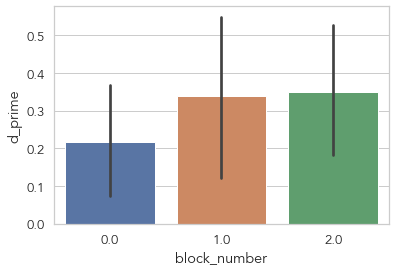

In [817]:
sns.barplot(data = d_blocks,
            y = 'd_prime',
            x = 'block_number')

In [818]:
d_commmon = df_zip.groupby(['gameID','common']).apply(d_primes).reset_index()
d_commmon = d_commmon.rename(columns = {0: 'd_prime'})

<AxesSubplot:xlabel='common', ylabel='d_prime'>

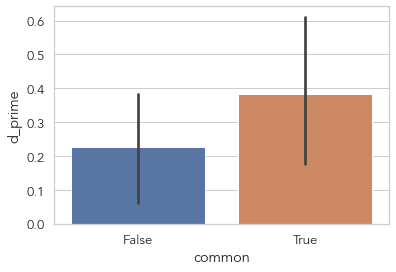

In [819]:
sns.barplot(data = d_commmon,
            y = 'd_prime',
            x = 'common')

In [820]:
d_common_duration = df_zip.groupby(['gameID','common','composite_duration']).apply(d_primes).reset_index()
d_common_duration = d_common_duration.rename(columns = {0: 'd_prime'})
d_common_duration

,gameID,common,composite_duration,d_prime
0,0168-7a5c4c65-3f9c-439f-b6e6-5510ea492e0e,False,100,1.177850
1,0168-7a5c4c65-3f9c-439f-b6e6-5510ea492e0e,True,100,1.010212
2,0304-f84e750f-063a-4aa2-a237-652a38724edc,False,100,1.027504
3,0304-f84e750f-063a-4aa2-a237-652a38724edc,True,100,1.162492
4,0312-0a145e71-ab67-4635-b618-3308086cdec4,False,100,0.695025
...,...,...,...,...
83,9665-1c0e01df-f416-4ec2-a24f-a5c145318b9d,True,100,-0.215780
84,9686-0ce88b1b-0953-4f1d-bfef-f2fdad6be5bd,False,300,0.449745
85,9686-0ce88b1b-0953-4f1d-bfef-f2fdad6be5bd,True,300,0.379027
86,9791-021d86b8-10a5-4fb3-b51f-92579687ecd3,False,300,0.579418


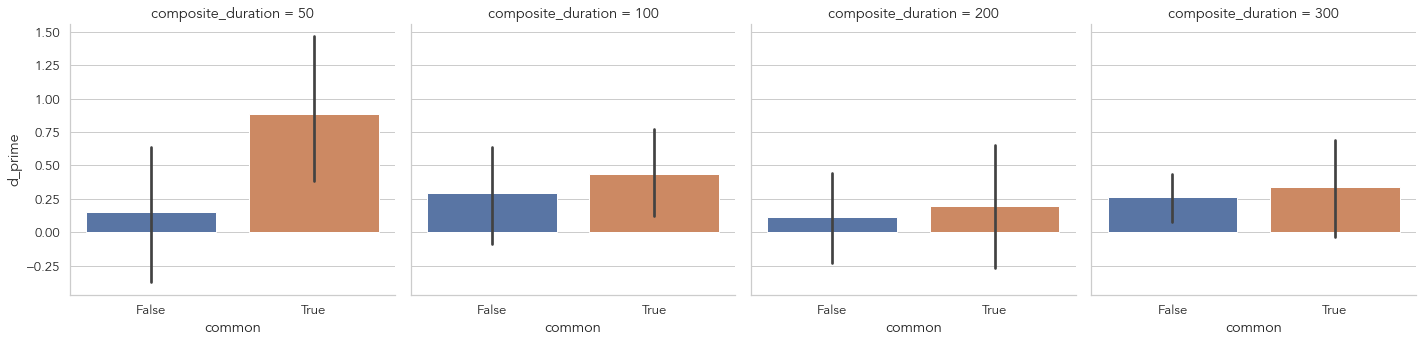

In [821]:
sns.catplot(data = d_common_duration,
            col = 'composite_duration',
            y = 'd_prime',
            x = 'common',
            kind='bar')

In [822]:
d_common_block = df_zip.groupby(['gameID','common','block_number']).apply(d_primes).reset_index()
d_common_block = d_common_block.rename(columns = {0: 'd_prime'})
d_common_block

,gameID,common,block_number,d_prime
0,0168-7a5c4c65-3f9c-439f-b6e6-5510ea492e0e,False,0.0,0.884918
1,0168-7a5c4c65-3f9c-439f-b6e6-5510ea492e0e,False,1.0,2.326348
2,0168-7a5c4c65-3f9c-439f-b6e6-5510ea492e0e,False,2.0,1.105217
3,0168-7a5c4c65-3f9c-439f-b6e6-5510ea492e0e,True,0.0,0.000000
4,0168-7a5c4c65-3f9c-439f-b6e6-5510ea492e0e,True,1.0,0.536694
...,...,...,...,...
259,9791-021d86b8-10a5-4fb3-b51f-92579687ecd3,False,1.0,0.292932
260,9791-021d86b8-10a5-4fb3-b51f-92579687ecd3,False,2.0,0.756993
261,9791-021d86b8-10a5-4fb3-b51f-92579687ecd3,True,0.0,-0.430727
262,9791-021d86b8-10a5-4fb3-b51f-92579687ecd3,True,1.0,0.292932


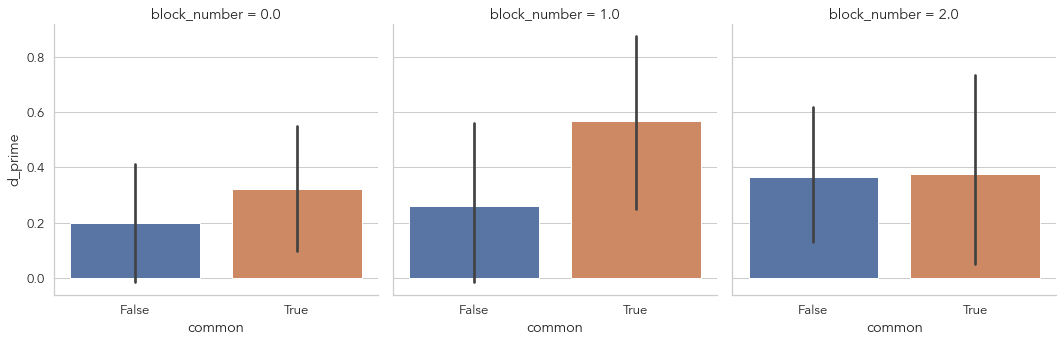

In [823]:
sns.catplot(data = d_common_block,
            col = 'block_number',
            y = 'd_prime',
            x = 'common',
            kind='bar')

In [824]:
d_block_duration = df_zip.groupby(['gameID','block_number','composite_duration']).apply(d_primes).reset_index()
d_block_duration = d_block_duration.rename(columns = {0: 'd_prime'})
d_block_duration

,gameID,block_number,composite_duration,d_prime
0,0168-7a5c4c65-3f9c-439f-b6e6-5510ea492e0e,0.0,100,0.493578
1,0168-7a5c4c65-3f9c-439f-b6e6-5510ea492e0e,1.0,100,1.172566
2,0168-7a5c4c65-3f9c-439f-b6e6-5510ea492e0e,2.0,100,1.698872
3,0304-f84e750f-063a-4aa2-a237-652a38724edc,0.0,100,1.183142
4,0304-f84e750f-063a-4aa2-a237-652a38724edc,1.0,100,1.278361
...,...,...,...,...
127,9686-0ce88b1b-0953-4f1d-bfef-f2fdad6be5bd,1.0,300,0.108211
128,9686-0ce88b1b-0953-4f1d-bfef-f2fdad6be5bd,2.0,300,0.862788
129,9791-021d86b8-10a5-4fb3-b51f-92579687ecd3,0.0,300,0.104633
130,9791-021d86b8-10a5-4fb3-b51f-92579687ecd3,1.0,300,0.292932


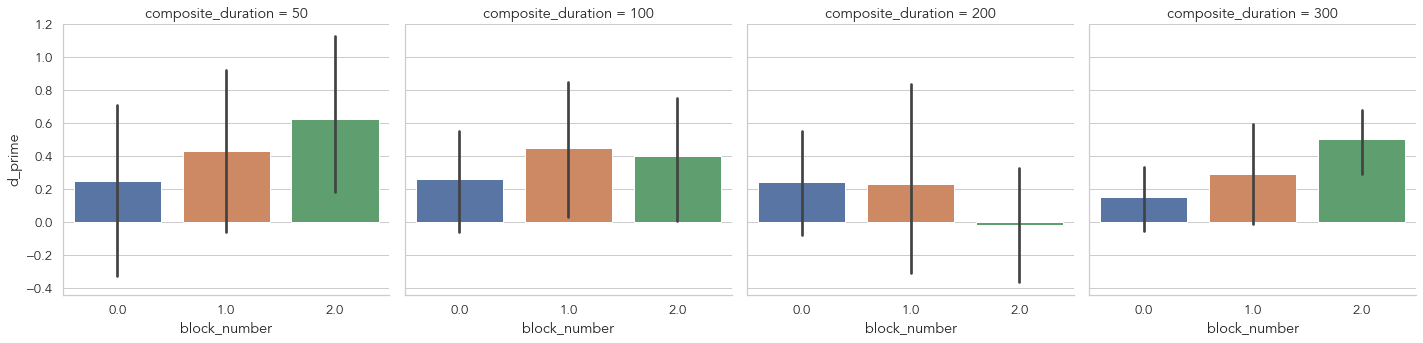

In [825]:
sns.catplot(data = d_block_duration,
            col = 'composite_duration',
            y = 'd_prime',
            x = 'block_number',
            kind='bar')

In [826]:
d_compatibility_block_duration = df_zip.groupby(['gameID','common','block_number','composite_duration']).apply(d_primes).reset_index()
d_compatibility_block_duration = d_compatibility_block_duration.rename(columns = {0: 'd_prime'})
d_compatibility_block_duration

,gameID,common,block_number,composite_duration,d_prime
0,0168-7a5c4c65-3f9c-439f-b6e6-5510ea492e0e,False,0.0,100,0.884918
1,0168-7a5c4c65-3f9c-439f-b6e6-5510ea492e0e,False,1.0,100,2.326348
2,0168-7a5c4c65-3f9c-439f-b6e6-5510ea492e0e,False,2.0,100,1.105217
3,0168-7a5c4c65-3f9c-439f-b6e6-5510ea492e0e,True,0.0,100,0.000000
4,0168-7a5c4c65-3f9c-439f-b6e6-5510ea492e0e,True,1.0,100,0.536694
...,...,...,...,...,...
259,9791-021d86b8-10a5-4fb3-b51f-92579687ecd3,False,1.0,300,0.292932
260,9791-021d86b8-10a5-4fb3-b51f-92579687ecd3,False,2.0,300,0.756993
261,9791-021d86b8-10a5-4fb3-b51f-92579687ecd3,True,0.0,300,-0.430727
262,9791-021d86b8-10a5-4fb3-b51f-92579687ecd3,True,1.0,300,0.292932


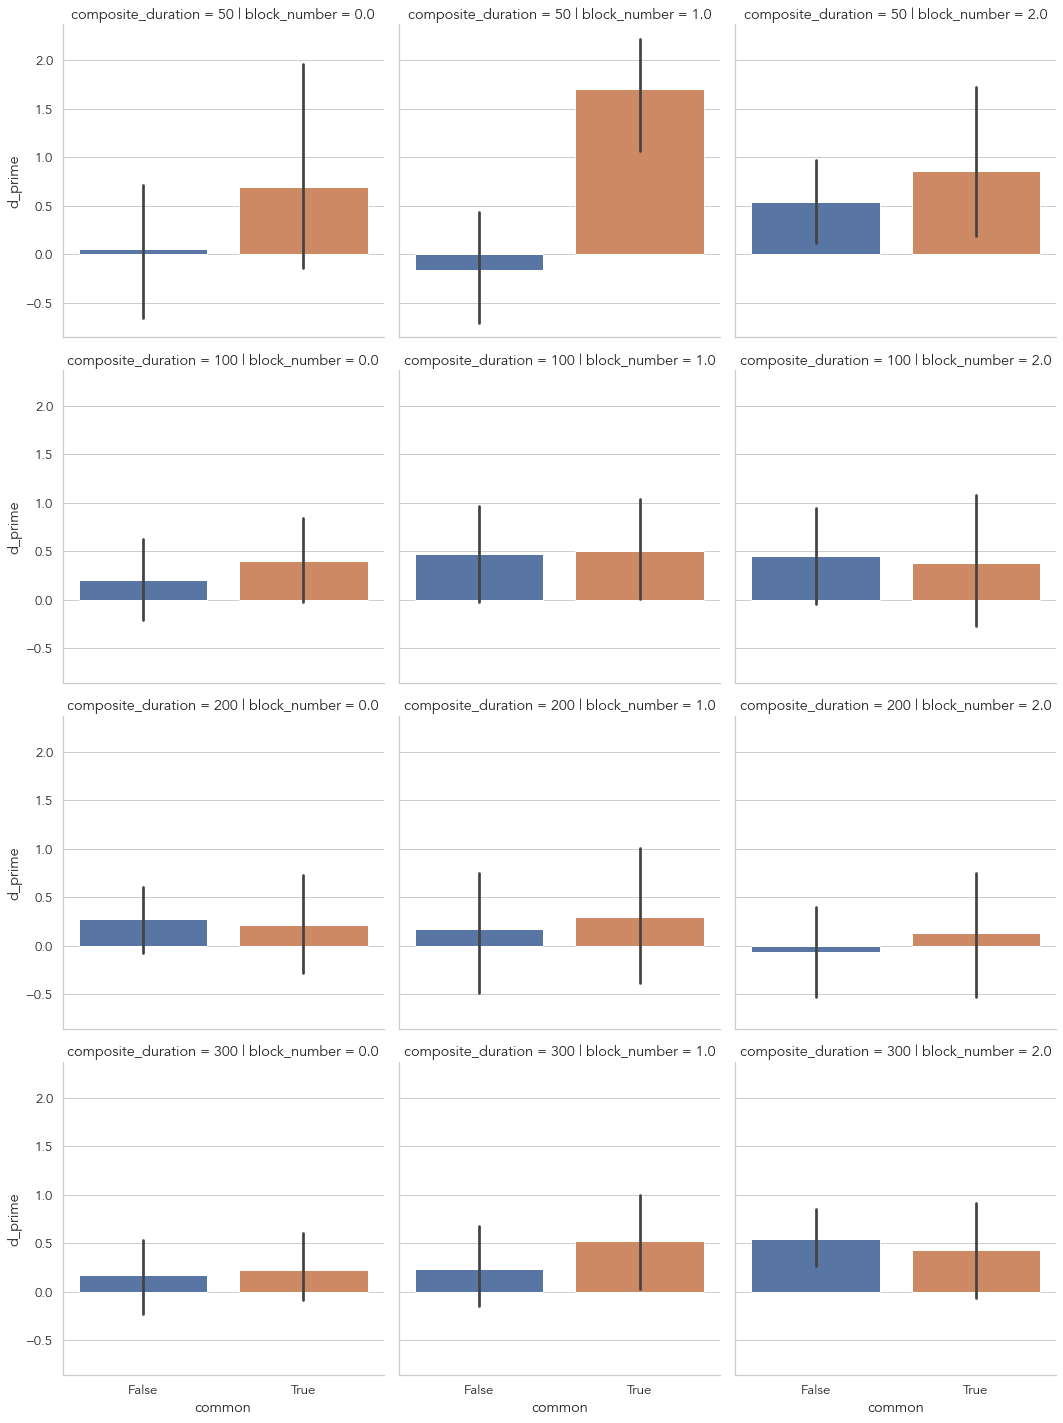

In [827]:
sns.catplot(data = d_compatibility_block_duration,
            col = 'block_number',
            row = 'composite_duration',
            y = 'd_prime',
            x = 'common',
            kind='bar')

### Duration

How does the amount of time the composite stimulus is displayed for affect things?

No handles with labels found to put in legend.


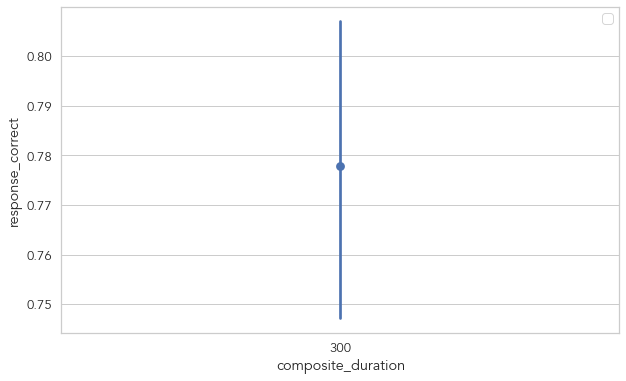

In [157]:
fig = plt.figure(figsize=(10,6))
sns.pointplot(data=df_zip, 
              y="response_correct", 
              x="composite_duration",
#               hue="compatibility"
             )
plt.legend(bbox_to_anchor=(1.0,1))

<AxesSubplot:xlabel='composite_duration', ylabel='rt'>

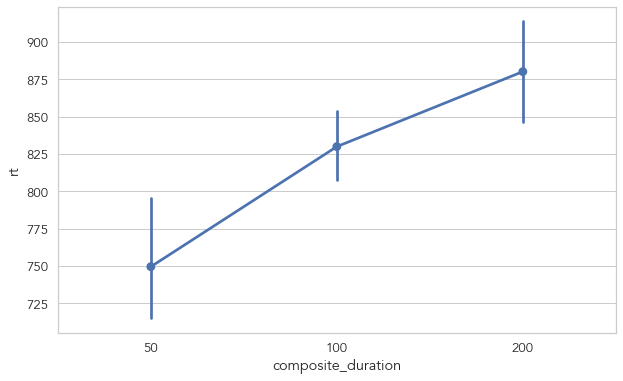

In [505]:
fig = plt.figure(figsize=(10,6))

sns.pointplot(data=df_zip[~df_zip.flagRT], 
              y="rt", 
              x="composite_duration")

In [506]:
fig = plt.figure(figsize=(10,6))

sns.pointplot(data=df_zip[~df_zip.flagRT], 
              y="rt",
              x="composite_duration",
              hue="compatibility")
plt.legend(bbox_to_anchor=(1.0,1))

ValueError: Could not interpret input 'compatibility'

<Figure size 720x432 with 0 Axes>

# Learning effects

Looks like there are substantial learning effects

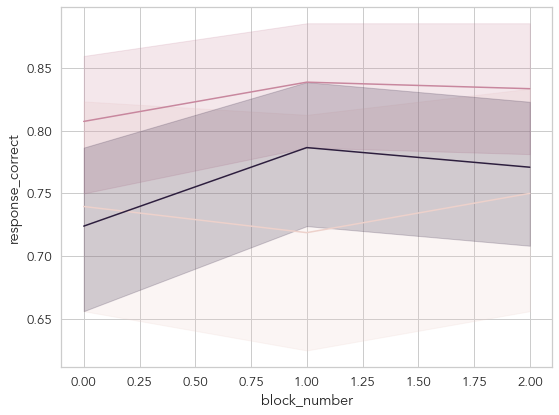

In [507]:
fig = plt.figure(figsize=(8,6))

c = sns.lineplot(data=df_zip, 
                y= "response_correct", 
                x= "block_number",
                hue="composite_duration",
#                 ci=None,
                legend=None)
# plt.legend(bbox_to_anchor=(1.0,1))

plt.tight_layout()

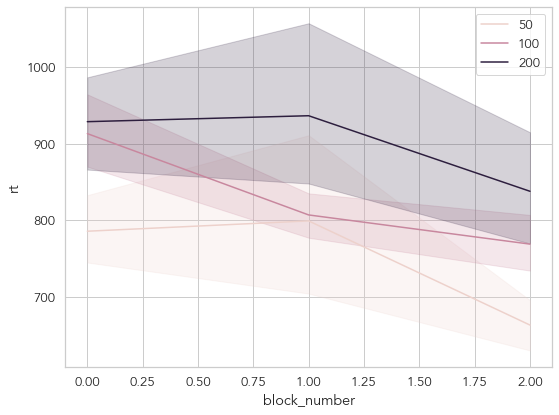

In [508]:
fig = plt.figure(figsize=(8,6))

c = sns.lineplot(data=df_zip, 
                y= "rt", 
                x= "block_number",
                hue="composite_duration")
plt.legend(bbox_to_anchor=(1.0,1))

plt.tight_layout()

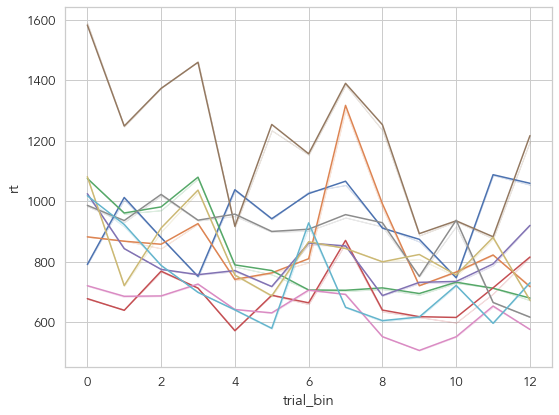

In [509]:
fig = plt.figure(figsize=(8,6))

c = sns.lineplot(data=df_zip[~df_zip.flagRT], 
                y= "rt",
                x = "trial_bin",
                hue= "gameID",
                ci=False,
                legend=False)

plt.tight_layout()

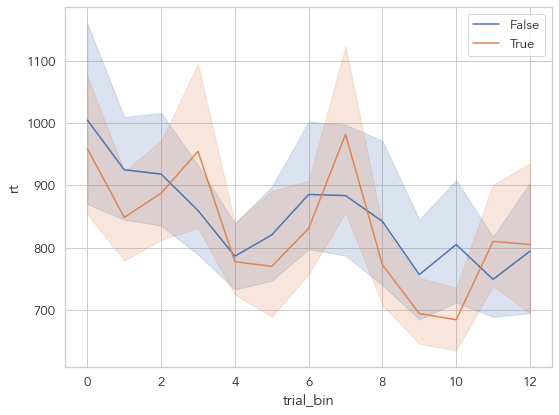

In [511]:
fig = plt.figure(figsize=(8,6))

c = sns.lineplot(data=df_zip[~df_zip.flagRT], 
                y= "rt",
                x = "trial_bin",
                hue= "common")
plt.legend(bbox_to_anchor=(1.0,1))

plt.tight_layout()

### Do people become more accurate over time?

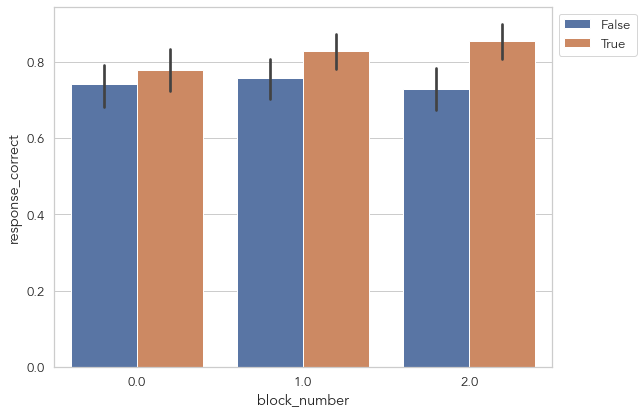

In [514]:
# over blocks (of 48 trials)?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct",
                x = "block_number",
                hue = "common")

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

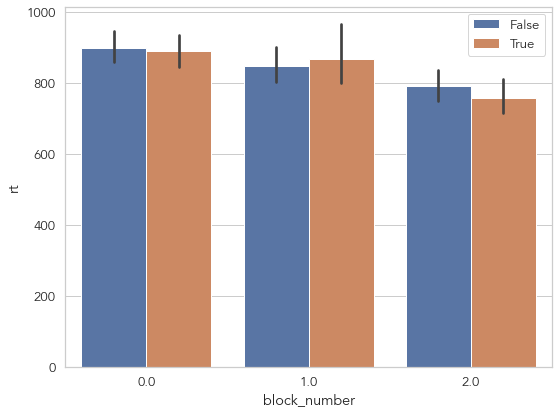

In [515]:
# over blocks (of 48 trials)?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "rt",
                x = "block_number",
                hue = "common")

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

They do get a bit better

Let's see if this happens for all durations

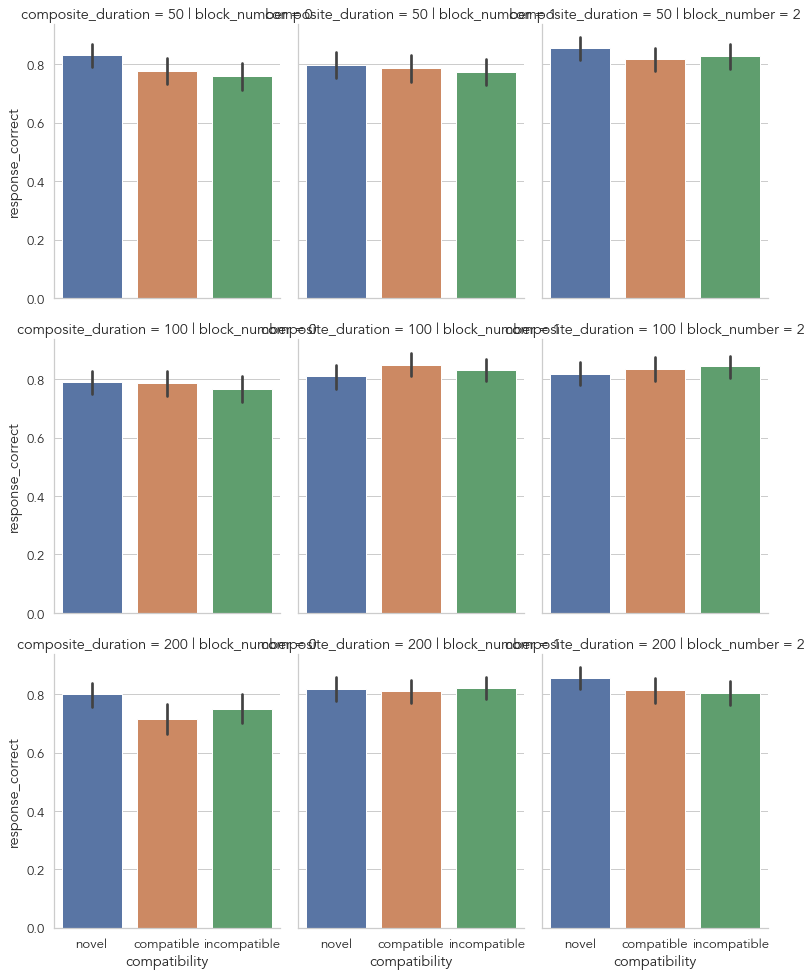

In [878]:
# rt over blocks, broken down by duration

g = sns.catplot(col="block_number",
                row="composite_duration", 
                y="response_correct", 
                x="compatibility",
                order=compatibility_order,
                dodge=True,
                kind="bar",
                data=df_zip,
                height=4.6,
                aspect=0.8)

### RT over time

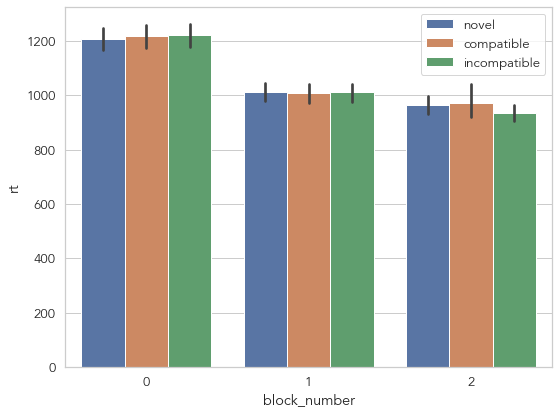

In [879]:
# over blocks (of 48 trials)?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "rt",
                x = "block_number",
                hue = "compatibility",
                hue_order = compatibility_order,)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

They get a lot faster with practice!

Let's see if this happens for all durations

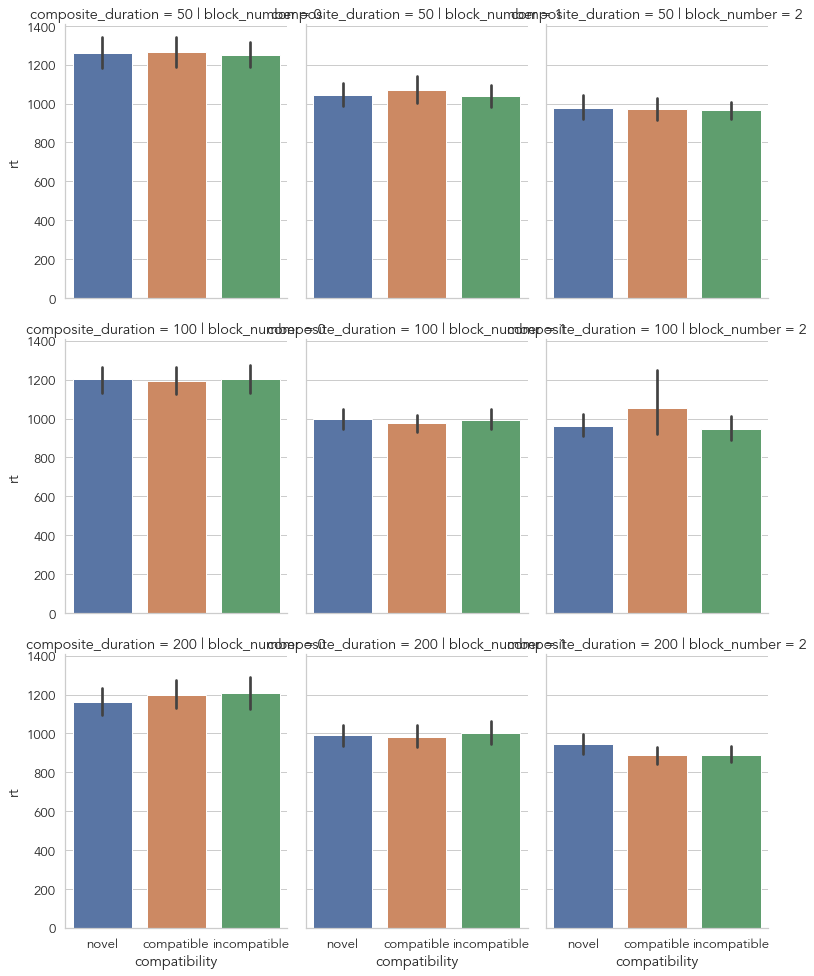

In [880]:
# rt over blocks, broken down by duration

g = sns.catplot(col="block_number",
                row="composite_duration", 
                y="rt", 
                x="compatibility",
                order=compatibility_order,
                dodge=True,
                kind="bar",
                data=df_zip,
                height=4.6,
                aspect=0.8)

### Validity

Looks like valid trials might be a little easier

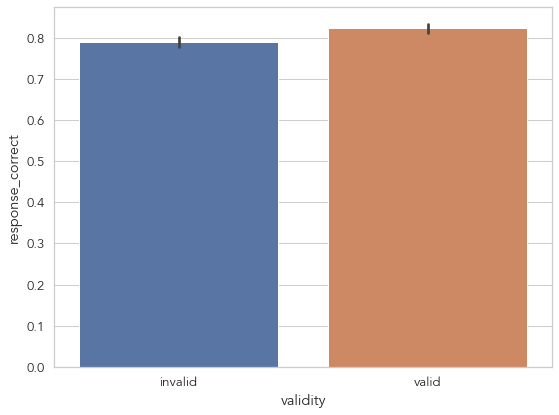

In [881]:
# are valid trials more accurate?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x="validity"
                )

plt.tight_layout()

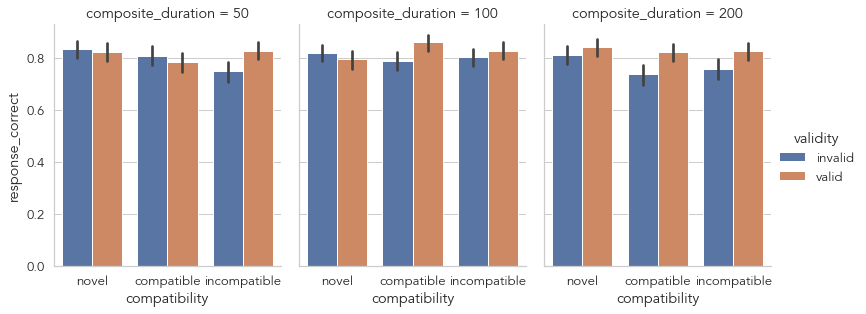

In [882]:
# Are people more accurate in valid trials in all conditions?

g = sns.catplot(col="composite_duration", 
                hue="validity",
                y="response_correct", 
                x="compatibility",
                order=['novel','compatible','incompatible'],
                dodge=True,
                kind="bar",
                data=df_zip,
                height=4.6,
                aspect=0.8)

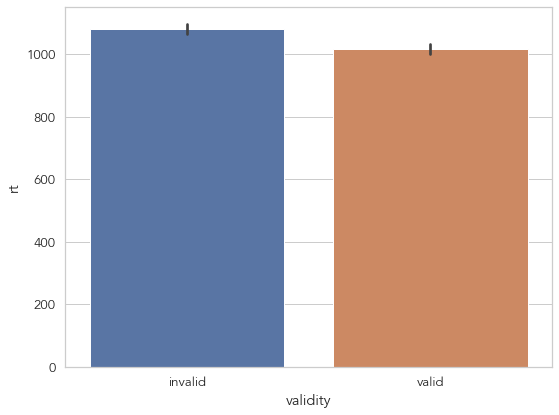

In [883]:
# are valid trials faster?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt", 
                x="validity")

plt.tight_layout()

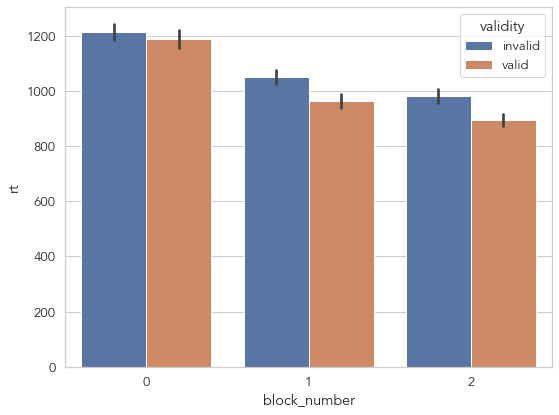

In [884]:
# are valid trials faster?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt", 
                hue="validity",
                x="block_number")

plt.tight_layout()

### Part type (tall vs. wide)

Vertical decomposition is easier

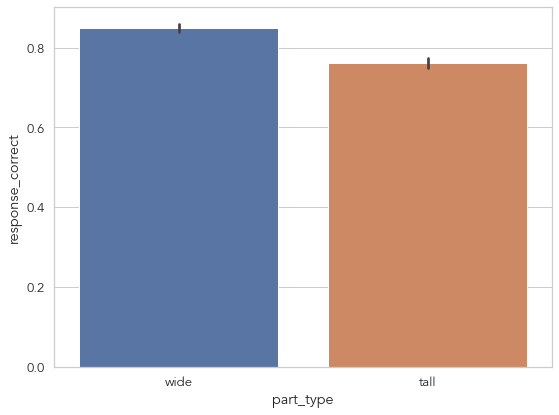

In [885]:
# Is either part type easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x="part_type")

plt.tight_layout()

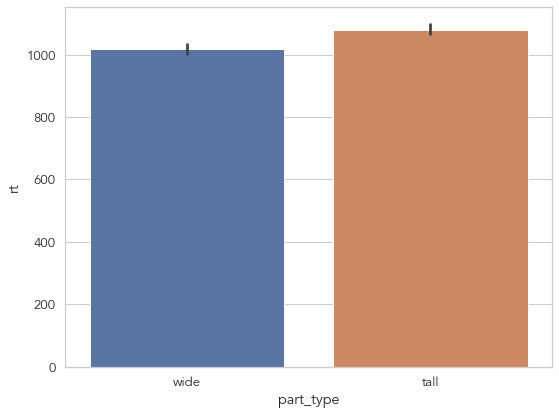

In [886]:
# Is either part type easier- rt?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt", 
                x="part_type")

plt.tight_layout()

### Stimuli

Are some stims easier than others?

In [887]:
import requests

In [888]:
stim_order = ['https://tower-4-block-unique-silhouettes-composite-silhouette-png.s3.amazonaws.com/tower_4_block_unique_silhouette_composites_silhouette_talls_100_118.png',
       'https://tower-4-block-unique-silhouettes-composite-silhouette-png.s3.amazonaws.com/tower_4_block_unique_silhouette_composites_silhouette_talls_122_127.png',
       'https://tower-4-block-unique-silhouettes-composite-silhouette-png.s3.amazonaws.com/tower_4_block_unique_silhouette_composites_silhouette_talls_102_126.png']

In [889]:
composite_id_order = [url.split('composites_silhouette_')[1].split('.')[0] for url in stim_order]
composite_id_order

['talls_100_118', 'talls_122_127', 'talls_102_126']

In [890]:
def show(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

talls_100_118


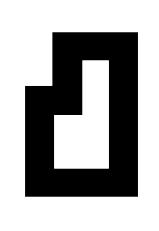

In [891]:
print(stim_order[0].split('silhouette_')[-1].split('.')[0])
show(stim_order[0])

talls_122_127


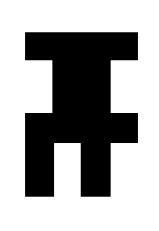

In [892]:
print(stim_order[1].split('silhouette_')[-1].split('.')[0])
show(stim_order[1])

talls_102_126


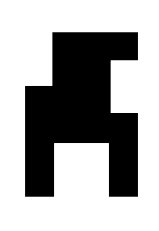

In [893]:
print(stim_order[2].split('silhouette_')[-1].split('.')[0])
show(stim_order[2])

One of the stimuli (talls_100_118) is considerably easier than the others.

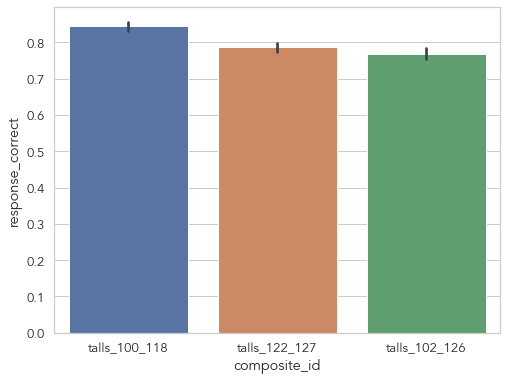

In [1677]:
# Is either stimulus easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "composite_id",
                order= composite_id_order)


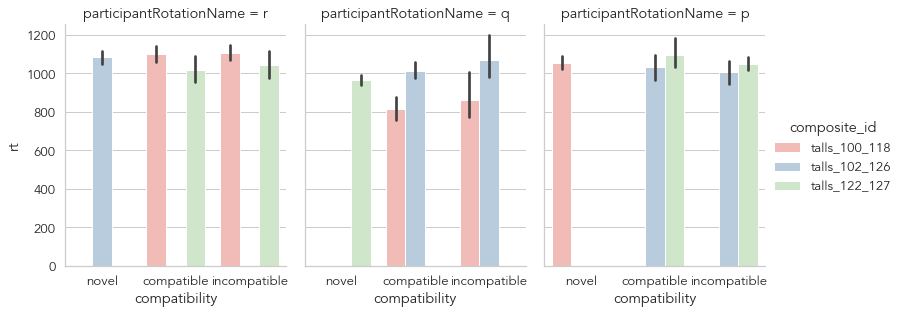

In [1735]:
# Are people more accurate in compatible trials?

g = sns.catplot(col="participantRotationName", 
                y="rt", 
                hue="composite_id",
                palette='Pastel1',
                x="compatibility",
                order= compatibility_order,
                dodge=True,
                kind="bar",
                data=df_zip,
                height=4.6,
                aspect=0.8)

In [ ]:
df_zip.participantRotationName

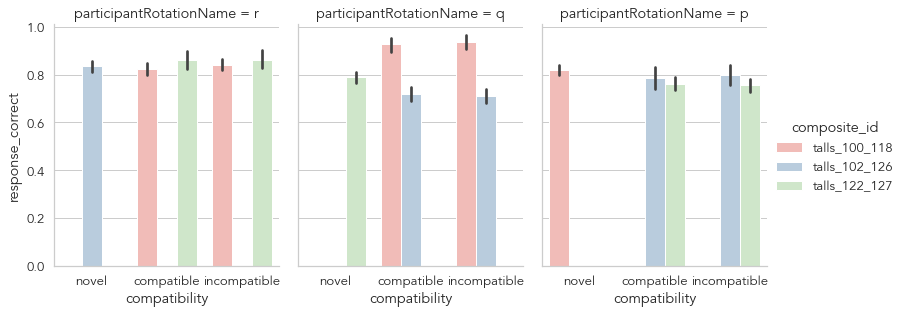

In [1674]:
# Are people more accurate in compatible trials?

g = sns.catplot(col="participantRotationName", 
                y="response_correct", 
                hue="composite_id",
                palette='Pastel1',
                x="compatibility",
                order= compatibility_order,
                dodge=True,
                kind="bar",
                data=df_zip,
                height=4.6,
                aspect=0.8)

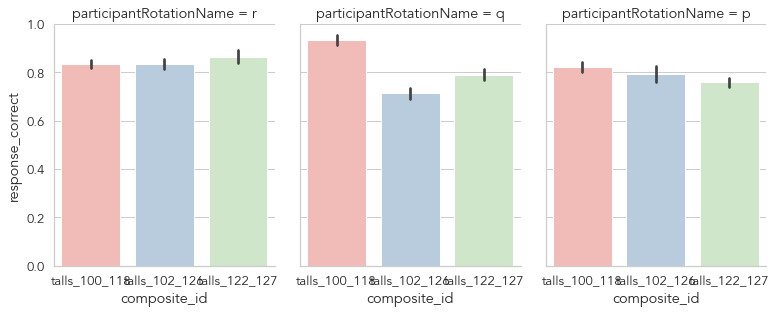

In [1676]:
# Are people more accurate in compatible trials?

g = sns.catplot(col="participantRotationName", 
                y="response_correct", 
#                 hue="composite_id",
                palette='Pastel1',
                x="composite_id",
#                 order= compatibility_order,
                dodge=True,
                kind="bar",
                data=df_zip,
                height=4.6,
                aspect=0.8)

In [1671]:
df_zip.groupby(['participantRotationName','participant_condition'])

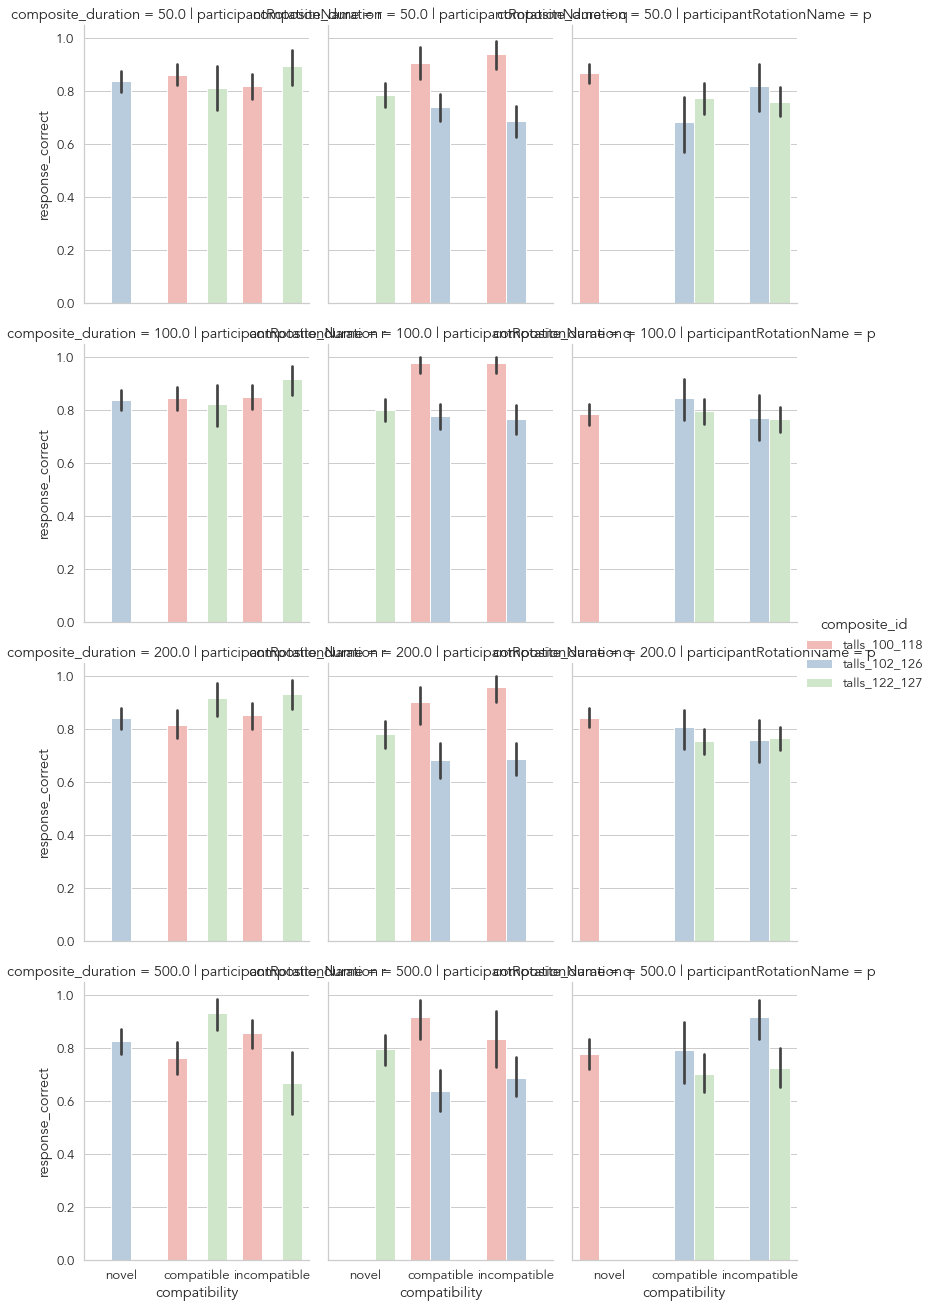

In [1642]:
# Are people more accurate in compatible trials?

g = sns.catplot(col="participantRotationName", 
                row="composite_duration",
                y="response_correct", 
                hue="composite_id",
                palette='Pastel1',
                x="compatibility",
                order= compatibility_order,
                dodge=True,
                kind="bar",
                data=df_zip,
                height=4.6,
                aspect=0.8)

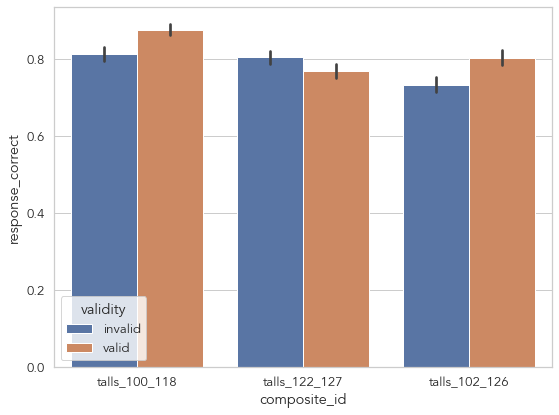

In [1645]:
# Is either stimulus easier at saying one particular way?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "composite_id",
                hue="validity",
               order= composite_id_order)

plt.tight_layout()

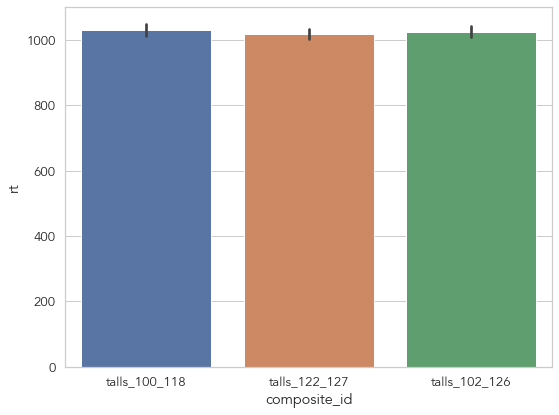

In [1644]:
# Is any composite easier- rt?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt", 
                x= "composite_id",
                order= composite_id_order)

plt.tight_layout()

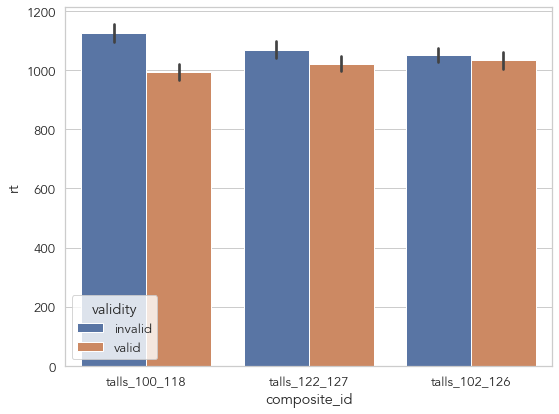

In [899]:
# Is either part type easier at saying one particular way- rt?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt", 
                x= "composite_id",
                order = composite_id_order,
                hue="validity")

plt.tight_layout()

In [900]:
df_zip.columns

Index(['level_0', 'index', '_id', 'rt', 'stimulus', 'response',
       'response_correct', 'stimURL', 'composite_id', 'rep', 'block_number',
       'composite_duration', 'gap_duration', 'chunk_duration',
       'participant_condition', 'compatible_trial', 'validity',
       'composite_talls_name', 'composite_wides_name', 'part_type', 'part_a',
       'part_b', 'participantRotationName', 'participantRotation',
       'stimVersion', 'stimVersionInd', 'compatible_condition', 'trial_type',
       'trial_index', 'time_elapsed', 'internal_node_id', 'datatype',
       'experimentName', 'iterationName', 'gameID', 'built_parts',
       'compatibility', 'trial_bin', 'flagRT', 'trial_num'],
      dtype='object')

In [390]:
# Is either part type easier at saying one particular way?

fig = plt.figure(figsize=(8,6))

c = sns.lineplot(data=df_zip, 
                y= "response_correct", 
                x= "trial_bin",
                hue="validity")

plt.tight_layout()

ValueError: Could not interpret value `trial_bin` for parameter `x`

<Figure size 576x432 with 0 Axes>

## Stimuli

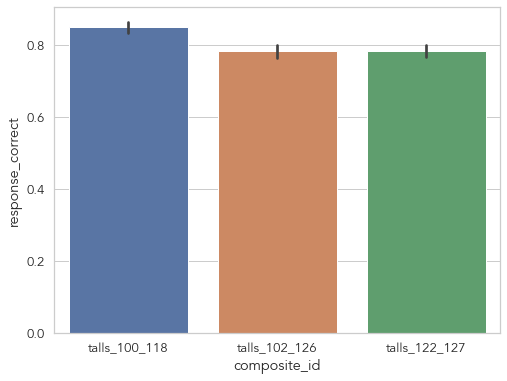

In [147]:
# Is either stimulus easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "composite_id")
#                 hue="composite_id")


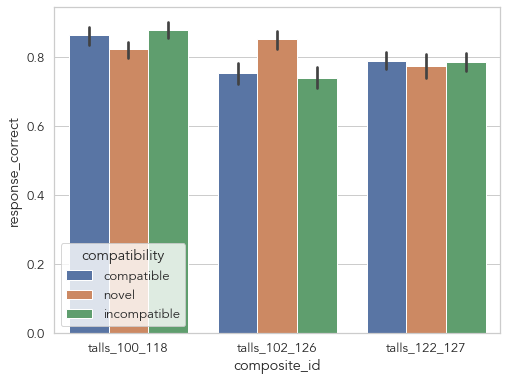

In [149]:
# Is either stimulus easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "composite_id",
               hue="compatibility")


In [135]:
df_zip.columns

Index(['index', '_id', 'rt', 'stimulus', 'response', 'response_correct',
       'stimURL', 'composite_id', 'rep', 'block_number', 'composite_duration',
       'gap_duration', 'chunk_duration', 'participant_condition',
       'compatible_trial', 'validity', 'composite_talls_name',
       'composite_wides_name', 'part_type', 'part_a', 'part_b',
       'participantRotationName', 'participantRotation', 'stimVersion',
       'stimVersionInd', 'compatible_condition', 'trial_type', 'trial_index',
       'time_elapsed', 'internal_node_id', 'datatype', 'experimentName',
       'iterationName', 'gameID', 'compatibility', 'trial_bin', 'flagRT',
       'trial_num'],
      dtype='object')

In [128]:
df_zip[['participantRotation','participantRotationName']].iloc[0][0]

{'B': 'talls_122_127&wides_025_023',
 'novel': 'talls_102_126&wides_024_011',
 'A': 'talls_100_118&wides_013_010'}

In [132]:
df_zip[['participantRotation','participantRotationName']].iloc[200][0]

{'novel': 'talls_122_127&wides_025_023',
 'A': 'talls_102_126&wides_024_011',
 'B': 'talls_100_118&wides_013_010'}

In [ ]:
df_zip['participantRotation'][0]

In [339]:
df_zip.com

0       talls_100_
1       wides_025_
2       wides_013_
3       talls_122_
4       talls_100_
           ...    
1327    wides_024_
1328    wides_013_
1329    wides_011_
1330    wides_025_
1331    talls_126_
Name: part_a, Length: 1332, dtype: object

In [375]:
# part a
'composite_' + df_zip.part_type + 's_name'

0       composite_talls_name
1       composite_wides_name
2       composite_wides_name
3       composite_talls_name
4       composite_talls_name
                ...         
1327    composite_wides_name
1328    composite_wides_name
1329    composite_wides_name
1330    composite_wides_name
1331    composite_talls_name
Name: part_type, Length: 1332, dtype: object

In [388]:
df_zip.composite_talls_name.apply(lambda x: x.split('_')[-2:])

0       [122, 127]
1       [102, 126]
2       [122, 127]
3       [102, 126]
4       [100, 118]
           ...    
1327    [102, 126]
1328    [100, 118]
1329    [100, 118]
1330    [122, 127]
1331    [100, 118]
Name: composite_talls_name, Length: 1332, dtype: object

In [387]:
df_zip.composite_wides_name.apply(lambda x: x.split('_')[-2:])

0       [025, 023]
1       [024, 011]
2       [025, 023]
3       [024, 011]
4       [013, 010]
           ...    
1327    [024, 011]
1328    [013, 010]
1329    [013, 010]
1330    [025, 023]
1331    [013, 010]
Name: composite_wides_name, Length: 1332, dtype: object

In [392]:
# part a

df_zip.part_a.apply(lambda x: x.split('_')[1])

0       100
1       025
2       013
3       122
4       100
       ... 
1327    024
1328    013
1329    011
1330    025
1331    126
Name: part_a, Length: 1332, dtype: object

In [396]:
df_zip.columns

0       invalid
1       invalid
2       invalid
3       invalid
4         valid
         ...   
1327      valid
1328      valid
1329    invalid
1330    invalid
1331    invalid
Name: validity, Length: 1332, dtype: object

In [414]:
def check_parts(row):
    
    part_type = row.part_type
    part_a = row.part_a.split('_')[1]
    part_b = row.part_b.split('_')[1]
    
    
    if row.validity == 'valid':
        if part_type == 'tall':
            return part_type + 's_'+ part_a + '_' + part_b == row.composite_talls_name
        else:
            return part_type + 's_'+ part_a + '_' + part_b == row.composite_wides_name
    else: # invalid trials
        if part_type == 'wide':
            return (part_a not in row.composite_wides_name.split('_')[-2:]) and \
                   (part_b not in row.composite_wides_name.split('_')[-2:]) 
        else:
            return (part_a not in row.composite_talls_name.split('_')[-2:]) and \
                   (part_b not in row.composite_talls_name.split('_')[-2:]) 
    
    return (part_type, part_a, part_b)
    

dodgy_trials = df_zip.apply(lambda row: not check_parts(row), axis=1)


In [439]:
df_zip.columns

Index(['Unnamed: 0', 'index', '_id', 'rt', 'stimulus', 'response',
       'response_correct', 'stimURL', 'composite_id', 'rep', 'block_number',
       'composite_duration', 'gap_duration', 'chunk_duration',
       'participant_condition', 'compatible_trial', 'validity',
       'composite_talls_name', 'composite_wides_name', 'part_type', 'part_a',
       'part_b', 'participantRotationName', 'participantRotation',
       'stimVersion', 'stimVersionInd', 'compatible_condition', 'trial_type',
       'trial_index', 'time_elapsed', 'internal_node_id', 'datatype',
       'experimentName', 'iterationName', 'workerID', 'gameID',
       'compatibility', 'trial_bin', 'flagRT'],
      dtype='object')

In [458]:
df_zip[dodgy_trials][['gameID','part_a','part_b','part_type','composite_talls_name',
                      'composite_wides_name','validity','rep','compatibility']]#.groupby(['gameID','compatibility']).count()                     
                     
                     
                     

,gameID,part_a,part_b,part_type,composite_talls_name,composite_wides_name,validity,rep,compatibility
58,5932-1c8afdaa-3e62-4179-89e1-cac0c71b27a1,wide_025,wide_011,wide,talls_102_126,wides_024_011,invalid,2,compatible
67,5932-1c8afdaa-3e62-4179-89e1-cac0c71b27a1,tall_122,tall_126,tall,talls_102_126,wides_024_011,invalid,2,incompatible
88,7793-230b9c9f-94fe-4dc2-83cf-0b4841ee723f,tall_102,tall_118,tall,talls_100_118,wides_013_010,invalid,2,compatible
94,7793-230b9c9f-94fe-4dc2-83cf-0b4841ee723f,wide_024,wide_010,wide,talls_100_118,wides_013_010,invalid,2,incompatible
106,2420-26aa2daa-eb8b-4f9d-a573-bf768f18f3a2,wide_013,wide_023,wide,talls_122_127,wides_025_023,invalid,2,incompatible
...,...,...,...,...,...,...,...,...,...
1278,6103-27acfb95-944a-43dd-9c19-1a9b2bc27f86,wide_025,wide_010,wide,talls_122_127,wides_025_023,invalid,3,compatible
1316,6103-27acfb95-944a-43dd-9c19-1a9b2bc27f86,tall_100,tall_127,tall,talls_122_127,wides_025_023,invalid,2,incompatible
1317,6103-27acfb95-944a-43dd-9c19-1a9b2bc27f86,wide_013,wide_023,wide,talls_122_127,wides_025_023,invalid,2,compatible
1321,6103-27acfb95-944a-43dd-9c19-1a9b2bc27f86,tall_122,tall_118,tall,talls_122_127,wides_025_023,invalid,3,incompatible


In [443]:
# part b
df_zip.part_b.apply(lambda x: x.split('_')[1])

0       126
1       023
2       011
3       127
4       118
       ... 
1327    011
1328    010
1329    025
1330    010
1331    122
Name: part_b, Length: 1332, dtype: object

In [ ]:
# Is either stimulus easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "participantRotationName",
                hue="compatibility")

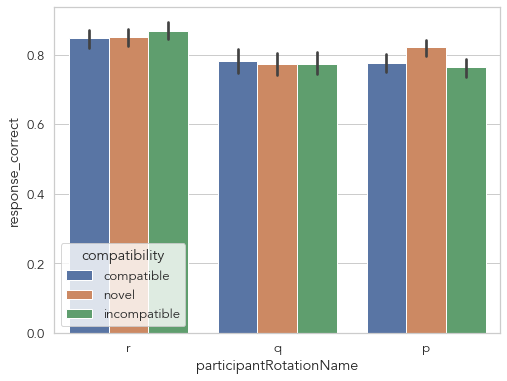

In [98]:
# Is either stimulus easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "participantRotationName",
                hue="compatibility")

### Condition (A vs. B) - DOESN'T APPLY ANYMORE

Is one condition easier than the others?
A looks a bit easier.

In [238]:
# how many people in each condition
df_zip.groupby('gameID').first().value_counts('participant_condition')

participant_condition
1    5
2    5
dtype: int64

#### Participant condition

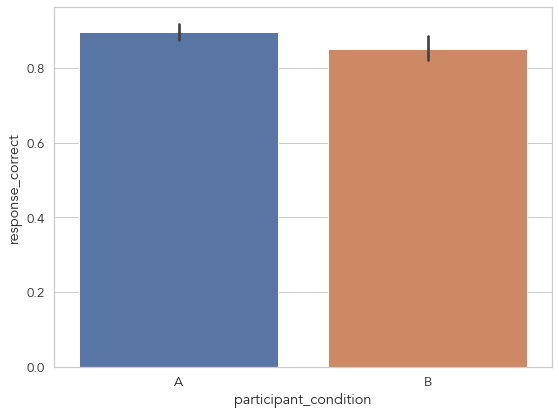

In [767]:
# Is either part type easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "participant_condition")

plt.tight_layout()

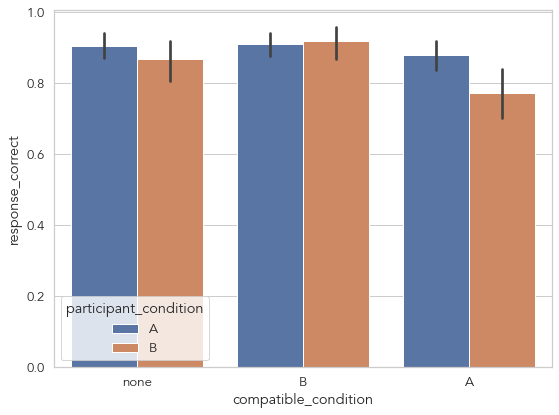

In [768]:
# break down by 

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "compatible_condition",
                hue="participant_condition")

plt.tight_layout()

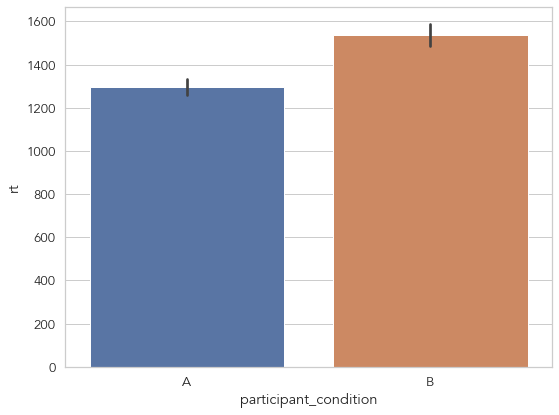

In [769]:
# Is either part type easier- rt?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt", 
                x= "participant_condition")

plt.tight_layout()

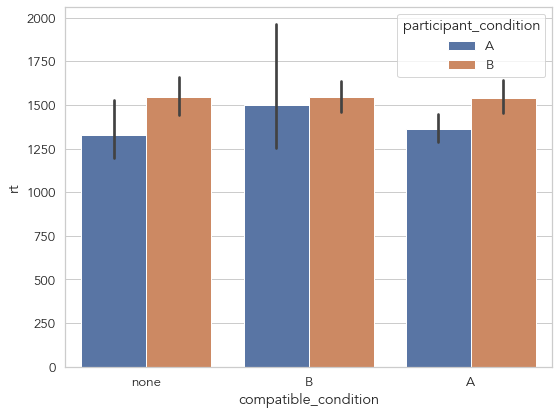

In [770]:
# Is either part type easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "rt", 
                x= "compatible_condition",
                hue="participant_condition")

plt.tight_layout()

In [1740]:
df_zip.part_a

0        wide_024
1        tall_122
2        tall_102
3        tall_102
4        tall_102
           ...   
10939    tall_100
10940    wide_025
10941    tall_118
10942    tall_102
10943    wide_024
Name: part_a, Length: 10944, dtype: object